<a href="https://colab.research.google.com/github/hunarpreet1/TradeAnomaly/blob/main/PriceVolumneAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!pip install ta
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0e5f866f5e1fb80b8cd53151467dd41746cc1b9369b6be29a87dbd793b8abb5a
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

folder_path = '/content/drive/My Drive/PriceData'

In [5]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
priceData = pd.read_csv(folder_path + '/' + 'pricedata.csv')
universe = pd.read_csv(folder_path + '/' + 'nse200universe.csv')
#nifty50 = pd.read_csv(folder_path + '/' + 'NiftyTRI_Index.csv')
#nifty200 = pd.read_csv(folder_path + '/' + 'NSE200TRI_Index.csv')

In [10]:
universe.drop("Unnamed: 0", axis=1, inplace=True)
universe.columns = pd.to_datetime(universe.columns)

In [11]:
universe.drop(200, inplace=True)

In [12]:
priceData['security'] = priceData['security'].str.replace(' IN Equity', '', regex=False)

In [13]:
universe = universe.applymap(lambda x: str(x).replace(' IS', '') if pd.notnull(x) else x)

<ipython-input-13-d19ebc0da713>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  universe = universe.applymap(lambda x: str(x).replace(' IS', '') if pd.notnull(x) else x)


In [14]:
# around 3% data has volume missing
# around 0.1% data has price missing
priceData.set_index('date', inplace=True)
#nifty50.set_index('date', inplace=True)
#nifty200.set_index('date', inplace=True)

priceData.index = pd.to_datetime(priceData.index)
#nifty50.index = pd.to_datetime(nifty50.index)
#nifty200.index = pd.to_datetime(nifty200.index)

priceData.dropna(inplace=True) # Think about Nans later.....
#nifty50.fillna(method="ffill", inplace=True)
#nifty50.fillna(method="bfill", inplace=True)

#nifty200.fillna(method="ffill", inplace=True)
#nifty200.fillna(method="bfill", inplace=True) # can fill same as PX_LAST ????

In [15]:
nifty200['PX_HIGH'].plot() # Many missing non close values

NameError: name 'nifty200' is not defined

In [16]:
priceData["totalVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("sum")
priceData["maxStockVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("max")
priceData["volume_ratio"] = priceData["PX_VOLUME"] / priceData["totalVolume"]
priceData["volume_max_ratio"] = priceData["PX_VOLUME"] / priceData["maxStockVolume"]

# priceData['returnsOpen'] = priceData.groupby('security')['PX_OPEN'].pct_change()
# priceData['returnsClose'] = priceData.groupby('security')['PX_LAST'].pct_change()
# priceData['returnsHigh'] = priceData.groupby('security')['PX_HIGH'].pct_change()
# priceData['returnsLow'] = priceData.groupby('security')['PX_LOW'].pct_change()
#priceData.dropna(inplace=True) # Think about Nans later.....

In [17]:
import numpy as np
def add_return_features(price_df):
    df = price_df.copy()
    grouped = df.groupby('security')

    # Previous close
    df['prev_close'] = grouped['PX_LAST'].shift(1)

    # Simple returns
    df['ret_close_to_close'] = (df['PX_LAST'] - df['prev_close']) / df['prev_close']
    df['ret_open_to_close']  = (df['PX_LAST'] - df['PX_OPEN']) / df['PX_OPEN']
    df['ret_close_to_open']  = (df['PX_OPEN'] - df['prev_close']) / df['prev_close']
    df['ret_intraday_range'] = (df['PX_HIGH'] - df['PX_LOW']) / df['PX_LOW']

    # Log returns
    df['log_ret_close_to_close'] = np.log(df['PX_LAST'] / df['prev_close'])
    df['log_ret_open_to_close']  = np.log(df['PX_LAST'] / df['PX_OPEN'])
    df['log_ret_close_to_open']  = np.log(df['PX_OPEN'] / df['prev_close'])
    df['log_ret_intraday_range'] = np.log(df['PX_HIGH'] / df['PX_LOW'])

    return df.dropna(subset=[
        'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range',
        'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range'
    ])

priceData = add_return_features(priceData)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#Extract candle stick/technical features

> Add blockquote



In [20]:
import pandas as pd
import numpy as np
import ta

import pandas as pd

def calculate_mfi(df, period=14, high_col="PX_HIGH", low_col="PX_LOW", close_col="PX_LAST", volume_col="PX_VOLUME", epsilon=1e-6):
    """
    Calculate Money Flow Index (MFI).

    Parameters:
    df (pd.DataFrame): DataFrame with OHLCV data.
    period (int): Lookback period for MFI (default=14).
    high_col, low_col, close_col, volume_col (str): Column names for high, low, close, and volume.

    Returns:
    pd.Series: Money Flow Index values.
    """
    # Typical Price
    df["TP"] = (df[high_col] + df[low_col] + df[close_col]) / 3

    # Money Flow
    df["MF"] = df["TP"] * df[volume_col]

    # Positive & Negative Money Flow
    df["Positive MF"] = df["MF"].where(df["TP"].diff() > 0, 0)
    df["Negative MF"] = df["MF"].where(df["TP"].diff() < 0, 0)

    # Money Flow Ratio
    df["MFR"] = df["Positive MF"].rolling(window=period).sum() / (df["Negative MF"].rolling(window=period).sum() + epsilon)


    # Money Flow Index
    df["MFI"] = 100 - (100 / (1 + df["MFR"]))

    return df["MFI"]

def extract_features(df):
    """
    Extracts technical features from OHLCV (PX_OPEN, PX_HIGH, PX_LOW, PX_LAST, PX_VOLUME) data.

    Parameters:
    df (pd.DataFrame): DataFrame with columns ['Date', 'security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'PX_VOLUME'].

    Returns:
    pd.DataFrame: DataFrame with added feature columns.
    """
    df = df.copy()

    # === Basic Price Features ===
    df["Daily_Return"] = df.groupby("security")["PX_LAST"].pct_change()
    #df["Log_Return"] = df.groupby("security")["PX_LAST"].apply(lambda x: np.log(x / x.shift(1)))
    df["Price_Spread"] = df["PX_HIGH"] - df["PX_LOW"]
    df["Body_Size"] = abs(df["PX_LAST"] - df["PX_OPEN"])
    df["Upper_Shadow"] = df["PX_HIGH"] - df[["PX_OPEN", "PX_LAST"]].max(axis=1)
    df["Lower_Shadow"] = df[["PX_OPEN", "PX_LAST"]].min(axis=1) - df["PX_LOW"]
    df["Close_Open_Gap"] = (df["PX_OPEN"] - df.groupby("security")["PX_LAST"].shift(1)) / df.groupby("security")["PX_LAST"].shift(1)
    df["Volume_Change"] = df.groupby("security")["PX_VOLUME"].pct_change()

    # === Trend Indicators ===
    df["SMA_5"] = df.groupby("security")["PX_LAST"].transform(lambda x: x.rolling(5).mean())
    df["SMA_20"] = df.groupby("security")["PX_LAST"].transform(lambda x: x.rolling(20).mean())
    df["EMA_12"] = ta.trend.EMAIndicator(df["PX_LAST"], window=12).ema_indicator()
    df["EMA_26"] = ta.trend.EMAIndicator(df["PX_LAST"], window=26).ema_indicator()
    df["MACD"] = ta.trend.MACD(df["PX_LAST"]).macd()
    df["MACD_Signal"] = ta.trend.MACD(df["PX_LAST"]).macd_signal()
    df["RSI"] = ta.momentum.RSIIndicator(df["PX_LAST"], window=14).rsi()

    # === Volatility Indicators ===
    df["ATR"] = ta.volatility.AverageTrueRange(df["PX_HIGH"], df["PX_LOW"], df["PX_LAST"], window=14).average_true_range()
    bollinger = ta.volatility.BollingerBands(df["PX_LAST"], window=20, window_dev=2)
    df["Bollinger_Upper"] = bollinger.bollinger_hband()
    df["Bollinger_Lower"] = bollinger.bollinger_lband()
    #df["Historical_Volatility"] = df.groupby("security")["Log_Return"].transform(lambda x: x.rolling(20).std())

    # === Momentum Indicators ===
    df["Momentum_5"] = ta.momentum.ROCIndicator(df["PX_LAST"], window=5).roc()
    df["Williams_%R"] = ta.momentum.WilliamsRIndicator(df["PX_HIGH"], df["PX_LOW"], df["PX_LAST"], lbp=14).williams_r()

    # Money Flow Index
    df["MFI"] = calculate_mfi(df)

    return df

# === Apply Feature Extraction to Dataset ===
priceData = extract_features(priceData)  # df contains multiple securities
priceData.dropna(inplace=True)

In [21]:
def getStockPriceVolumeData(ticker, start=None, end=None):
  stock_data = priceData[priceData['security'] == ticker]
  if start is not None:
    stock_data = stock_data.loc[start:]
  if end is not None:
    stock_data = stock_data.loc[:end]
  return stock_data

def plotPrice(ticker, priceType='PX_OPEN', start=None, end=None, dotDates=None, lineDates=None, saveFig=True, folder_path='', saveSuffix=''):
  df = getStockPriceVolumeData(ticker, start=start, end=end)
  plt.close("all")  # Close any previous plots
  fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure explicitly

  ax.plot(df.index, df[priceType], label=priceType, color='black')

  # Formatting
  ax.set_xlabel("Date")
  ax.set_ylabel(priceType)
  ax.set_title(ticker)
  ax.legend()
  plt.xticks(rotation=45)
  plt.grid()
  ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts date labels
  fig.autofmt_xdate()  # Rotates dates for better readability
  start = pd.Timestamp(start) if start is not None else df.index[0]
  end = pd.Timestamp(end) if end is not None else df.index[-1]

  if dotDates is not None:
    dotDates = [date for date in dotDates if date >= start and date <= end]
    plt.scatter(dotDates, df.loc[dotDates, priceType], color='red', zorder=3, label="Dots")

  if lineDates is not None:
    lineDates = [pd.Timestamp(date) for date in lineDates if start <= pd.Timestamp(date) <= end]
    print(lineDates)
    for date in lineDates:
        plt.axvline(x=date, color='blue', linestyle='--', linewidth=1, alpha=0.7, label="Event" if date == lineDates[0] else "")

  if saveFig:
    plt.savefig(folder_path + '/' + ticker + '_' + saveSuffix + '.png', bbox_inches="tight")
    #print(f"Plot saved to {save_path}")

  plt.show()

#Remove Index component from stock price

In [22]:
IN_EQUITY_PREFIX = ''
CURR_UNIVERSE = [ ticker for ticker in universe['2022-12-30'] if pd.notna(ticker) ]

In [23]:
import pandas as pd
import numpy as np

import pandas as pd

def backfill_index_composition(df, start_date='2000-01-01', freq='D'):
    """
    Backfills an index composition DataFrame to an earlier start date.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame where:
        - Columns are dates (datetime or string)
        - Index represents constituents (0-199 for NIFTY 200)
        - Cells contain identifier strings
    start_date : str or datetime-like, optional
        The date to backfill to (default: '2000-01-01')
    freq : str, optional
        Frequency for date range (default: 'D' for daily)
        Use 'M' for monthly, 'Q' for quarterly, etc.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with composition backfilled to start_date

    Example:
    --------
    >>> backfilled_df = backfill_index_composition(nifty_df, start_date='2000-01-01')
    """
    # Convert dates if necessary
    if not isinstance(df.columns[0], pd.Timestamp):
        df.columns = pd.to_datetime(df.columns)

    # Get first available date from existing data
    end_date = df.columns[0]

    # Create date range for backfill period
    new_dates = pd.date_range(
        start=pd.to_datetime(start_date),
        end=end_date - pd.Timedelta(days=1),  # don't overlap with existing data
        freq=freq
    )

    # Get the earliest available composition
    earliest_composition = df.iloc[:, 0]

    # Create backfilled data
    backfill_data = pd.DataFrame(
        {date: earliest_composition for date in new_dates},
        index=df.index
    )

    # Combine with original data
    full_history = pd.concat([backfill_data, df], axis=1)

    # Sort columns chronologically and return
    return full_history.sort_index(axis=1)


import pandas as pd
import numpy as np

def compute_equal_weighted_returns(price_df,
                                   composition_df,
                                   price_col = 'PX_LAST'):
    """
    Compute equal-weighted index returns from long-form price data and daily index composition.

    Parameters:
    - price_df: pd.DataFrame with columns ['security', price_col], index as pd.DatetimeIndex
    - composition_df: pd.DataFrame with columns as pd.DatetimeIndex, values as security IDs
                      Each column represents the index composition on that date
    - price_col: str, name of the price column to use (default = 'close')

    Returns:
    - pd.Series of equal-weighted index returns with datetime index
    """

    price_df = price_df.copy()

    # # Group by 'security' to handle each stock separately
    # grouped = price_df.groupby('security')

    # # Shifted previous day's close per security
    # price_df['prev_close'] = grouped['PX_LAST'].shift(1)

    # # Simple returns
    # price_df['ret_close_to_close'] = (price_df['PX_LAST'] - price_df['prev_close']) / price_df['prev_close']
    # price_df['ret_open_to_close']  = (price_df['PX_LAST'] - price_df['PX_OPEN']) / price_df['PX_OPEN']
    # price_df['ret_close_to_open']  = (price_df['PX_OPEN'] - price_df['prev_close']) / price_df['prev_close']
    # price_df['ret_intraday_range'] = (price_df['PX_HIGH'] - price_df['PX_LOW']) / price_df['PX_LOW']

    # # Log returns
    # price_df['log_ret_close_to_close'] = np.log(price_df['PX_LAST'] / price_df['prev_close'])
    # price_df['log_ret_open_to_close']  = np.log(price_df['PX_LAST'] / price_df['PX_OPEN'])
    # price_df['log_ret_close_to_open']  = np.log(price_df['PX_OPEN'] / price_df['prev_close'])
    # price_df['log_ret_intraday_range'] = np.log(price_df['PX_HIGH'] / price_df['PX_LOW'])

    # # Drop rows where any return couldn't be computed
    # price_df = price_df.dropna(subset=[
    #     'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range',
    #     'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range'
    # ])


    # Filter composition dates to match available price dates
    valid_dates = price_df.index.unique()
    composition_df = composition_df.loc[:, composition_df.columns.intersection(valid_dates)]

    # Build composition map: date -> set of security IDs
    composition_map = {
        date: set(composition_df[date].dropna().values)
        for date in composition_df.columns
    }

    # Pre-filter columns
    price_df = price_df[['security', 'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range',
                         'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range']]

    # Compute equal-weighted returns
    index_returns = []
    for date in sorted(valid_dates):
        if date not in composition_map:
            index_returns.append((date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, num_constituents))
            continue

        securities = composition_map[date]
        day_data = price_df.loc[date]

        if isinstance(day_data, pd.Series):
            index_returns.append((date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, num_constituents))
            continue
            #day_data = pd.DataFrame([day_data])

        day_data = day_data[day_data['security'].isin(securities)]

        num_constituents = len(day_data)

        if(num_constituents < 100): # concern  ??? some 7-8 dates more if I keep the threshold to 150
          index_returns.append((date, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, num_constituents))
          continue

        ew_ret_close_to_close = day_data['ret_close_to_close'].mean() if not day_data.empty else np.nan
        ew_ret_open_to_close = day_data['ret_open_to_close'].mean() if not day_data.empty else np.nan
        ew_ret_close_to_open = day_data['ret_close_to_open'].mean() if not day_data.empty else np.nan
        ew_ret_intraday_range = day_data['ret_intraday_range'].mean() if not day_data.empty else np.nan
        log_ret_close_to_close = day_data['log_ret_close_to_close'].mean() if not day_data.empty else np.nan
        log_ret_open_to_close = day_data['log_ret_open_to_close'].mean() if not day_data.empty else np.nan
        log_ret_close_to_open = day_data['log_ret_close_to_open'].mean() if not day_data.empty else np.nan
        log_ret_intraday_range = day_data['log_ret_intraday_range'].mean() if not day_data.empty else np.nan
        index_returns.append((date, ew_ret_close_to_close, ew_ret_open_to_close, ew_ret_close_to_open, ew_ret_intraday_range, log_ret_close_to_close,
                              log_ret_open_to_close, log_ret_close_to_open, log_ret_intraday_range, num_constituents))

    return pd.DataFrame(index_returns, columns=['date', 'ew_ret_close_to_close', 'ew_ret_open_to_close', 'ew_ret_close_to_open', 'ew_ret_intraday_range',
                                                'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range', 'n_constituents']).set_index('date')

# Example Usage
index_composition_df = backfill_index_composition(universe, priceData.index.min())  # Extend composition first
equal_weighted_index_returns = compute_equal_weighted_returns(priceData, index_composition_df)


<Axes: xlabel='date'>

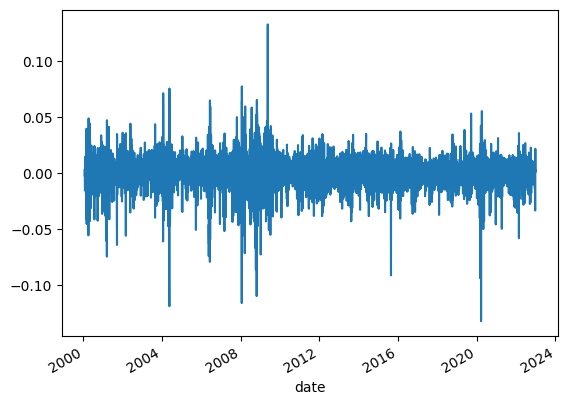

In [24]:
equal_weighted_index_returns['log_ret_close_to_close'].plot()

In [25]:
equal_weighted_index_returns = equal_weighted_index_returns.dropna()

In [ ]:
def create_security_data_dict(priceData):
    """
    Create a dictionary of per-security DataFrames from priceData.

    Parameters:
    - priceData (pd.DataFrame): Must contain 'security' column, indexed by pd.Timestamp.

    Returns:
    - dict: { security_name: small dataframe }
    """
    security_data_dict = {}

    # Group by security
    for security, sec_df in priceData.groupby('security'):
        # Drop 'security' column (optional, since we already know which security it is)
        sec_df = sec_df.drop(columns=['security'])

        # Store
        security_data_dict[security] = sec_df.sort_index()  # Ensure sorted by date

    return security_data_dict

security_data_dict = create_security_data_dict(priceData)

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import probplot
import logging
from datetime import datetime

import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"[{func.__name__}] executed in {end - start:.4f} seconds")
        return result
    return wrapper

def compute_log_returns(df):
    """ Compute log returns for a given price series. """
    return np.log(df / df.shift(1))

def compute_simple_returns(df):
    """ Compute simple returns for a given price series. """
    return df.pct_change()

def setup_logger(log_file='idiosyncratic_returns.log'):
    """Configure logging system"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

def generate_regression_plots(aligned_data, model, residuals, security, price_type):
    """Helper function to generate diagnostic plots."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"{security} - {price_type} Regression Diagnostics", y=1.02)

    plt.subplot(2, 2, 1)
    sns.regplot(x='index_return', y='stock_return', data=aligned_data,
                scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ci=None)
    plt.xlabel(f"Index {price_type} Returns")
    plt.ylabel(f"Stock {price_type} Returns")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.scatter(model.predict(), residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

RETURN_TYPES = ['ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range']
LOG_RETURN_TYPES = ['log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range']

from statsmodels.regression.rolling import RollingOLS

@timeit
def compute_idiosyncratic_returns(priceData, indexData, returnTypes=LOG_RETURN_TYPES,
                                universe=None, make_plots=False, merge_to_original=True,
                                log_stats=True, log_file='idiosyncratic_returns.log',
                                regression_results=None, security_data_dict=None,
                                verbose=False, use_rolling_ols=False, rolling_window=60):
    """
    Compute idiosyncratic returns with enhanced logging and rolling OLS option.

    Parameters:
    - priceData (pd.DataFrame): Original price data indexed by date with columns ['security', ...]
    - indexData (pd.DataFrame): Index prices with matching price types, indexed by date
    - returnTypes (list): Return types to process
    - universe (list): Securities to process (None=all available)
    - make_plots (bool): Generate diagnostic plots
    - merge_to_original (bool): Whether to merge results back to priceData
    - log_stats (bool): Whether to log regression statistics
    - log_file (str): Path to log file
    - regression_results (str): Path to CSV with alpha/beta if using pre-computed results
    - security_data_dict (dict): Optional preloaded {security: dataframe} to avoid repeated IO
    - verbose (bool): Print regression summaries if True
    - use_rolling_ols (bool): Use rolling OLS instead of full period OLS
    - rolling_window (int): Window size for rolling OLS

    Returns:
    - pd.DataFrame or dict: If merge_to_original=True returns enhanced DataFrame,
                            else returns dictionary of idiosyncratic returns
    """
    # Initialize logger
    logger = setup_logger(log_file)
    logger.info("Starting idiosyncratic returns computation")
    logger.info(f"Processing {len(returnTypes)} price types: {', '.join(returnTypes)}")

    if universe is None:
        universe = priceData['security'].unique()
        logger.info(f"Using default universe of {len(universe)} securities")
    else:
        logger.info(f"Processing custom universe of {len(universe)} securities")

    idio_dict = {rt: {} for rt in returnTypes}
    results = priceData.copy() if merge_to_original else None
    if merge_to_original:
      results = results.set_index('security', append=True)
    stats_records = []
    failed_securities = []

    missing_types = [rt for rt in returnTypes if rt not in indexData.columns]
    if missing_types:
        logger.error(f"Index data missing price types: {missing_types}")
        raise ValueError(f"Index data missing price types: {missing_types}")

    logger.info("Precomputed index returns for all price types")
    index_returns = {rt: indexData[rt].dropna() for rt in returnTypes}

    if regression_results:
        regression_results_df = pd.read_csv(regression_results)

    processed = 0
    for security in universe:
        try:
            if security_data_dict:
                sec_data = security_data_dict.get(security)
            else:
                sec_data = getStockPriceVolumeData(security)

            if sec_data is None or sec_data.empty:
                logger.warning(f"No data for {security}")
                failed_securities.append(security)
                continue

            for return_type in returnTypes:
                if return_type not in sec_data.columns:
                    continue

                stock_returns = sec_data[return_type].dropna()
                aligned_data = pd.concat([stock_returns, index_returns[return_type]], axis=1, join="inner").dropna()
                aligned_data.columns = ['stock_return', 'index_return']

                if len(aligned_data) < rolling_window:
                    logger.warning(f"Insufficient data points ({len(aligned_data)}) for {security} {return_type}")
                    continue

                if use_rolling_ols:
                    X = sm.add_constant(aligned_data['index_return'])
                    y = aligned_data['stock_return']

                    rolling_model = RollingOLS(y, X, window=rolling_window)
                    rolling_results = rolling_model.fit()

                    alpha = rolling_results.params['const']
                    beta = rolling_results.params['index_return']

                    fitted_values = alpha + beta * aligned_data['index_return']
                    alpha_plus_epsilon = y - fitted_values
                    alpha_plus_epsilon = alpha_plus_epsilon.dropna()

                    # import matplotlib.pyplot as plt

                    # plt.figure(figsize=(12, 6))
                    # beta.plot()
                    # plt.title(f'Rolling Beta for {security}')
                    # plt.xlabel('Date')
                    # plt.ylabel('Beta')
                    # plt.grid()
                    # plt.show()


                    # plt.figure(figsize=(12, 6))
                    # alpha.plot()
                    # plt.title(f'Rolling Alpha for {security}')
                    # plt.xlabel('Date')
                    # plt.ylabel('Alpha')
                    # plt.grid()
                    # plt.show()

                    # r2 = rolling_results.rsquared

                    # plt.figure(figsize=(12, 6))
                    # r2.plot()
                    # plt.title(f'Rolling R² for {security}')
                    # plt.xlabel('Date')
                    # plt.ylabel('R²')
                    # plt.ylim(0, 1)  # R² is between 0 and 1
                    # plt.grid()
                    # plt.show()



                else:
                    if regression_results:
                        regression_row = regression_results_df[
                            (regression_results_df['security'] == security) &
                            (regression_results_df['return_type'] == return_type)
                        ]
                        if regression_row.empty:
                            logger.warning(f"No regression results for {security} {return_type}")
                            continue
                        alpha = regression_row.iloc[0]['alpha']
                        beta = regression_row.iloc[0]['beta']
                        alpha_plus_epsilon = aligned_data['stock_return'] - beta * aligned_data['index_return']
                    else:
                        X = sm.add_constant(aligned_data['index_return'])
                        y = aligned_data['stock_return']
                        model = sm.OLS(y, X).fit()
                        residuals = y - model.predict(X)
                        beta = model.params[1]
                        alpha_plus_epsilon = y - beta * X['index_return']

                        if verbose:
                            print(f"{security}_{return_type} Regression | R² = {model.rsquared:.4f}")

                        stats_records.append({
                            'security': security,
                            'return_type': return_type,
                            'alpha': model.params[0],
                            'beta': model.params[1],
                            'r_squared': model.rsquared,
                            'observations': len(aligned_data)
                        })

                        if make_plots:
                            generate_regression_plots(aligned_data, model, residuals, security, return_type)

                idio_dict[return_type][security] = alpha_plus_epsilon
                processed += 1

                # if merge_to_original:
                #     valid_indices = alpha_plus_epsilon.index.intersection(results.index)
                #     mask = (results['security'] == security) & (results.index.isin(valid_indices))
                #     col_name = f"IDIO_{return_type}"
                #     results.loc[mask, col_name] = alpha_plus_epsilon.loc[valid_indices].values

                col_name = f"IDIO_{return_type}"


                if merge_to_original:
                # Create tuple index
                  target_idx = [(dt, security) for dt in alpha_plus_epsilon.index if (dt, security) in results.index]

                  if target_idx:
                      results.loc[target_idx, col_name] = alpha_plus_epsilon.loc[[idx[0] for idx in target_idx]].values


        except Exception as e:
            logger.exception(f"Failed for security {security}")
            failed_securities.append(security)
            continue

    logger.info(f"Finished processing. Successfully processed {processed} security/price-type combinations.")

    if log_stats and not regression_results and stats_records:
        stats_df = pd.DataFrame(stats_records)
        stats_df.to_csv("stats_output_regression.csv", index=False)
        logger.info("Saved regression statistics to CSV")

    if merge_to_original:
      results = results.reset_index().set_index('date')

    return (results if merge_to_original else idio_dict), failed_securities

priceData, failed = compute_idiosyncratic_returns(priceData, equal_weighted_index_returns, universe=CURR_UNIVERSE, merge_to_original=True, make_plots=False, regression_results=None, security_data_dict=security_data_dict, verbose=True, use_rolling_ols=True, rolling_window=180 )

[compute_idiosyncratic_returns] executed in 728.7379 seconds


In [ ]:
len(priceData[priceData['IDIO_log_ret_open_to_close'].notnull()]['security'].unique())

198

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import probplot
import logging
from datetime import datetime

import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"[{func.__name__}] executed in {end - start:.4f} seconds")
        return result
    return wrapper

def compute_log_returns(df):
    """ Compute log returns for a given price series. """
    return np.log(df / df.shift(1))

def compute_simple_returns(df):
    """ Compute simple returns for a given price series. """
    return df.pct_change()

def setup_logger(log_file='idiosyncratic_returns.log'):
    """Configure logging system"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

def generate_regression_plots(aligned_data, model, residuals, security, price_type):
    """Helper function to generate diagnostic plots."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"{security} - {price_type} Regression Diagnostics", y=1.02)

    plt.subplot(2, 2, 1)
    sns.regplot(x='index_return', y='stock_return', data=aligned_data,
                scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ci=None)
    plt.xlabel(f"Index {price_type} Returns")
    plt.ylabel(f"Stock {price_type} Returns")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.scatter(model.predict(), residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

RETURN_TYPES = [ 'ret_close_to_close', 'ret_open_to_close', 'ret_close_to_open', 'ret_intraday_range' ]
LOG_RETURN_TYPES = [ 'log_ret_close_to_close', 'log_ret_open_to_close', 'log_ret_close_to_open', 'log_ret_intraday_range' ]

@timeit
def compute_idiosyncratic_returns(priceData, indexData, returnTypes=LOG_RETURN_TYPES,
                                universe=None, make_plots=False, merge_to_original=True,
                                log_stats=True, log_file='idiosyncratic_returns.log', regression_results=None):
    """
    Compute idiosyncratic returns with enhanced logging functionality.

    Parameters:
    priceData (pd.DataFrame): Original price data indexed by date with columns ['security', ...]
    indexData (pd.DataFrame): Index prices with matching price types, indexed by date
    price_types (list): Price columns to process
    universe (list): Securities to process (None=all available)
    make_plots (bool): Generate diagnostic plots
    merge_to_original (bool): Whether to merge results back to priceData
    log_stats (bool): Whether to log regression statistics
    log_file (str): Path to log file

    Returns:
    pd.DataFrame or dict: If merge_to_original=True returns enhanced DataFrame,
                         else returns dictionary of idiosyncratic returns
    """
    # Initialize logger
    logger = setup_logger(log_file)
    logger.info("Starting idiosyncratic returns computation")
    logger.info(f"Processing {len(returnTypes)} price types: {', '.join(returnTypes)}")

    # Set default universe if not provided
    if universe is None:
        universe = priceData['security'].unique()
        logger.info(f"Using default universe of {len(universe)} securities")
    else:
        logger.info(f"Processing custom universe of {len(universe)} securities")

    # Initialize storage
    idio_dict = {rt: {} for rt in returnTypes}
    results = priceData.copy() if merge_to_original else None
    stats_records = []

    # Verify index price types
    missing_types = [rt for rt in returnTypes if rt not in indexData.columns]
    if missing_types:
        error_msg = f"Index data missing price types: {missing_types}"
        logger.error(error_msg)
        raise ValueError(error_msg)
    else:
        logger.info("All required price types present in index data")

    # Precompute index returns
    index_returns = { rt: indexData[rt].dropna() for rt in returnTypes }
    # index_returns = {'PX_LAST': indexData['log_ret'].dropna()
    #                   }
    logger.info("Precomputed index returns for all price types")

    processed = 0
    for security in universe:
        try:
            sec_data = getStockPriceVolumeData(security)
            if sec_data is None or sec_data.empty:
                logger.warning(f"No data available for security: {security}")
                continue

            for return_type in returnTypes:
                if return_type not in sec_data.columns:
                    logger.debug(f"Price type {return_type} not found for {security}")
                    continue

                # Calculate returns and align data
                stock_returns = sec_data[return_type].dropna()
                # print(type(stock_returns), '----------------')
                # print(stock_returns.index)
                # print(stock_returns)

                # # Store log returns in results DataFrame
                # if merge_to_original:
                #   valid_indices = stock_returns.index.intersection(results.index)
                #   log_return_col = f"LOGRET_{return_type}"
                #   mask = (results['security'] == security) & (results.index.isin(valid_indices))
                #   results.loc[mask, log_return_col] = stock_returns.loc[valid_indices].values

                aligned_data = pd.concat([stock_returns, index_returns[return_type]],
                                       axis=1, join="inner").dropna()
                aligned_data.columns = ['stock_return', 'index_return']


                if len(aligned_data) < 30:
                    logger.warning(f"Insufficient data points ({len(aligned_data)}) for {security} {return_type}")
                    continue

                # print(aligned_data.dtypes)
                # print(aligned_data.head())
                # print(type(index_returns[return_type]), '----------------')
                # print(index_returns[return_type].index)
                # print(index_returns[return_type])

                # Run regression
                if regression_results:
                  regression_results_df = pd.read_csv(regression_results)
                  regression_results_filtered_df = regression_results_df[
                                                      (regression_results_df['security'] == security) &
                                                      (regression_results_df['return_type'] == return_type)
                                                  ]
                  alpha = regression_results_filtered_df.iloc[0]['alpha']
                  beta = regression_results_filtered_df.iloc[0]['beta']
                  predicted = alpha + beta * aligned_data['index_return']
                  residuals = aligned_data['stock_return'] - predicted
                  alpha_plus_epsilon = aligned_data['stock_return'] - beta * aligned_data['index_return']

                else:
                  X = sm.add_constant(aligned_data['index_return'])
                  y = aligned_data['stock_return']
                  model = sm.OLS(y, X).fit()
                  residuals = y - model.predict(X)
                  beta = model.params[1]                     # beta
                  alpha_plus_epsilon = y - beta * X['index_return']

                  print(f"{security}_{return_type} Regression Finished | R² = {model.rsquared:.4f}")

                # Store results
                idio_dict[return_type][security] = alpha_plus_epsilon #
                processed += 1

                # Log regression statistics
                if log_stats and regression_results is None:
                    stats_records.append({
                        'security': security,
                        'return_type': return_type,
                        'alpha': model.params[0],
                        'beta': model.params[1],
                        'r_squared': model.rsquared,
                        'observations': len(aligned_data)
                    })

                # Merge if requested
                if merge_to_original:
                    valid_indices = alpha_plus_epsilon.index.intersection(results.index)
                    col_name = f"IDIO_{return_type}"
                    mask = (results['security'] == security) & (results.index.isin(valid_indices))
                    results.loc[mask, col_name] = alpha_plus_epsilon.loc[valid_indices].values

                # Generate plots if requested
                if make_plots and regression_results is None:
                    generate_regression_plots(aligned_data, model, residuals, security, return_type)

        except Exception as e:
            logger.error(f"Error processing {security}: {str(e)}", exc_info=True)
            continue

    # Final logging summary
    logger.info(f"Completed processing. Successfully processed {processed} security/price-type combinations")
    if log_stats and regression_results is None:
      stats_df = pd.DataFrame(stats_records)
      stats_df.to_csv("stats_output_regression.csv", index=False)

    return results if merge_to_original else idio_dict

priceData = compute_idiosyncratic_returns(priceData, equal_weighted_index_returns, universe=CURR_UNIVERSE, merge_to_original=True, make_plots=False, regression_results='stats_output_regression.csv')

[compute_idiosyncratic_returns] executed in 851.6376 seconds


<Axes: xlabel='date'>

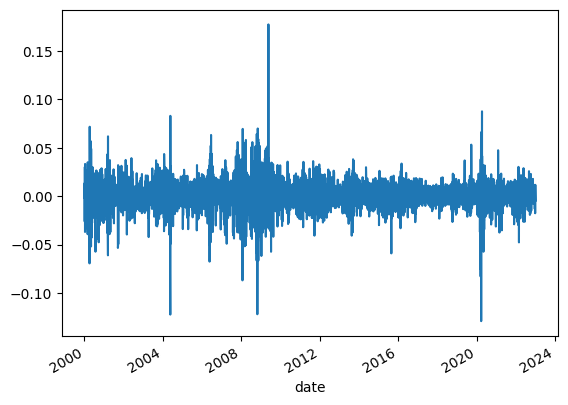

In [ ]:
nifty50['PX_LAST'].pct_change().plot()

In [ ]:
equal_weighted_index_returns[equal_weighted_index_returns['ew_ret_close_to_close'] <0.4]

,ew_ret_close_to_close,ew_ret_open_to_close,ew_ret_close_to_open,ew_ret_intraday_range,log_ret_close_to_close,log_ret_open_to_close,log_ret_close_to_open,log_ret_intraday_range,n_constituents
date,,,,,,,,,
1999-12-28,0.010969,0.014910,-0.003002,0.056933,0.009680,0.013152,-0.003472,0.054112,590
1999-12-29,-0.002987,-0.004654,0.001864,0.049635,-0.003840,-0.005213,0.001373,0.047999,622
1999-12-30,0.006633,0.002968,0.003843,0.057134,0.005828,0.002375,0.003453,0.054888,626
2000-01-03,0.075523,0.031226,0.044136,0.064491,0.072280,0.029831,0.042449,0.061247,625
2000-01-04,0.004905,-0.012325,0.017900,0.075610,0.003601,-0.013282,0.016883,0.072150,646
...,...,...,...,...,...,...,...,...,...
2022-12-26,0.022392,0.027695,-0.005087,0.045219,0.021822,0.026961,-0.005138,0.043862,1075
2022-12-27,0.010061,0.003107,0.006956,0.025361,0.009896,0.002997,0.006900,0.024973,1063
2022-12-28,0.000977,0.001075,-0.000071,0.023454,0.000886,0.000982,-0.000096,0.023094,1062


In [ ]:
priceData.tail()

,security,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EQY_WEIGHTED_AVG_PX,PX_VOLUME,totalVolume,maxStockVolume,volume_ratio,volume_max_ratio,returnsOpen,returnsClose,returnsHigh,returnsLow,LOGRET_PX_LAST,IDIO_PX_LAST
date,,,,,,,,,,,,,,,,,
2022-12-30,ORCP,365.00,374.00,360.00,364.05,364.2354,3380.0,3.340415e+09,316126759.0,0.000001,0.000011,0.020408,0.004969,0.019074,0.006430,NaN,NaN
2022-12-30,SUNF,117.40,118.60,111.35,112.25,115.4531,1138845.0,3.340415e+09,316126759.0,0.000341,0.003602,0.056230,-0.013620,0.018026,0.014579,NaN,NaN
2022-12-30,WH,1902.18,1930.60,1888.51,1899.64,1910.1009,26251.0,3.340415e+09,316126759.0,0.000008,0.000083,0.017035,-0.001335,-0.002954,0.024810,NaN,NaN
2022-12-30,OWF,112.20,112.95,110.05,111.10,111.8095,18736.0,3.340415e+09,316126759.0,0.000006,0.000059,0.004476,0.008625,0.000443,0.018981,NaN,NaN
2022-12-30,KS,354.97,363.70,347.34,348.94,356.1409,70202.0,3.340415e+09,316126759.0,0.000021,0.000222,0.007951,-0.010941,0.024046,0.002482,NaN,NaN


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import probplot
import logging
from datetime import datetime

def compute_log_returns(df):
    """ Compute log returns for a given price series. """
    return np.log(df / df.shift(1))

def compute_simple_returns(df):
    """ Compute simple returns for a given price series. """
    return df.pct_change()

def setup_logger(log_file='idiosyncratic_returns.log'):
    """Configure logging system"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

def compute_idiosyncratic_returns(priceData, indexData, price_types=['PX_LAST', 'PX_OPEN', 'PX_HIGH', 'PX_LOW'],
                                universe=None, make_plots=False, merge_to_original=True,
                                log_stats=True, log_file='idiosyncratic_returns.log'):
    """
    Compute idiosyncratic returns with enhanced logging functionality.

    Parameters:
    priceData (pd.DataFrame): Original price data indexed by date with columns ['security', ...]
    indexData (pd.DataFrame): Index prices with matching price types, indexed by date
    price_types (list): Price columns to process
    universe (list): Securities to process (None=all available)
    make_plots (bool): Generate diagnostic plots
    merge_to_original (bool): Whether to merge results back to priceData
    log_stats (bool): Whether to log regression statistics
    log_file (str): Path to log file

    Returns:
    pd.DataFrame or dict: If merge_to_original=True returns enhanced DataFrame,
                         else returns dictionary of idiosyncratic returns
    """
    # Initialize logger
    logger = setup_logger(log_file)
    logger.info("Starting idiosyncratic returns computation")
    logger.info(f"Processing {len(price_types)} price types: {', '.join(price_types)}")

    # Set default universe if not provided
    if universe is None:
        universe = priceData['security'].unique()
        logger.info(f"Using default universe of {len(universe)} securities")
    else:
        logger.info(f"Processing custom universe of {len(universe)} securities")

    # Initialize storage
    idio_dict = {pt: {} for pt in price_types}
    results = priceData.copy() if merge_to_original else None
    stats_records = []

    # Verify index price types
    missing_types = [pt for pt in price_types if pt not in indexData.columns]
    if missing_types:
        error_msg = f"Index data missing price types: {missing_types}"
        logger.error(error_msg)
        raise ValueError(error_msg)
    else:
        logger.info("All required price types present in index data")

    # Precompute index returns
    index_returns = {pt: compute_log_returns(indexData[pt]).dropna()
                    for pt in price_types}
    logger.info("Precomputed index returns for all price types")

    processed = 0
    for security in universe:
        try:
            sec_data = getStockPriceVolumeData(security)
            if sec_data is None or sec_data.empty:
                logger.warning(f"No data available for security: {security}")
                continue

            for price_type in price_types:
                if price_type not in sec_data.columns:
                    logger.debug(f"Price type {price_type} not found for {security}")
                    continue

                # Calculate returns and align data
                stock_returns = compute_log_returns(sec_data[price_type]).dropna()

                # Store log returns in results DataFrame
                if merge_to_original:
                  valid_indices = stock_returns.index.intersection(results.index)
                  log_return_col = f"LOGRET_{price_type}"
                  mask = (results['security'] == security + IN_EQUITY_PREFIX) & (results.index.isin(valid_indices))
                  results.loc[mask, log_return_col] = stock_returns.loc[valid_indices].values

                aligned_data = pd.concat([stock_returns, index_returns[price_type]],
                                       axis=1, join="inner").dropna()
                aligned_data.columns = ['stock_return', 'index_return']

                if len(aligned_data) < 30:
                    logger.warning(f"Insufficient data points ({len(aligned_data)}) for {security} {price_type}")
                    continue

                # Run regression
                X = sm.add_constant(aligned_data['index_return'])
                y = aligned_data['stock_return']
                model = sm.OLS(y, X).fit()
                residuals = y - model.predict(X)
                print(f"{security}_{price_type} Regression Finished | R² = {model.rsquared:.4f}")

                # Store results
                idio_dict[price_type][security] = residuals
                processed += 1

                # Log regression statistics
                if log_stats:
                    stats_records.append({
                        'security': security,
                        'price_type': price_type,
                        'alpha': model.params[0],
                        'beta': model.params[1],
                        'r_squared': model.rsquared,
                        'observations': len(aligned_data)
                    })

                # Merge if requested
                if merge_to_original:
                    valid_indices = residuals.index.intersection(results.index)
                    col_name = f"IDIO_{price_type}"
                    mask = (results['security'] == security + IN_EQUITY_PREFIX) & (results.index.isin(valid_indices))
                    results.loc[mask, col_name] = residuals.loc[valid_indices].values

                # Generate plots if requested
                if make_plots:
                    generate_regression_plots(aligned_data, model, residuals, security, price_type)

        except Exception as e:
            logger.error(f"Error processing {security}: {str(e)}", exc_info=True)
            continue

    # Final logging summary
    logger.info(f"Completed processing. Successfully processed {processed} security/price-type combinations")

    return results if merge_to_original else idio_dict

def generate_regression_plots(aligned_data, model, residuals, security, price_type):
    """Helper function to generate diagnostic plots."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"{security} - {price_type} Regression Diagnostics", y=1.02)

    plt.subplot(2, 2, 1)
    sns.regplot(x='index_return', y='stock_return', data=aligned_data,
                scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ci=None)
    plt.xlabel(f"Index {price_type} Returns")
    plt.ylabel(f"Stock {price_type} Returns")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.scatter(model.predict(), residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


#priceData = compute_idiosyncratic_returns(priceData, nifty200, universe=CURR_UNIVERSE[:30], merge_to_original=True, make_plots=True)

In [ ]:
df[df['security'] == 'ADANIGR IN Equity']

NameError: name 'df' is not defined

In [ ]:
nifty200.loc['2018-06-20']

,2018-06-20
Unnamed: 0,3605
security,NSE200TR Index
PX_OPEN,7113.24
PX_HIGH,7113.24
PX_LOW,7113.24
PX_LAST,7086.53
EQY_WEIGHTED_AVG_PX,NaN


In [ ]:
priceData.columns

Index(['security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST',
       'EQY_WEIGHTED_AVG_PX', 'PX_VOLUME', 'totalVolume', 'maxStockVolume',
       'volume_ratio', 'volume_max_ratio', 'returnsOpen', 'returnsClose',
       'returnsHigh', 'returnsLow'],
      dtype='object')

In [ ]:
CURR_UNIVERSE

#Model 1

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import pandas as pd
from datetime import datetime
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [27]:
'''
utoencoder Model: An autoencoder is implemented as a class AnomalyDetector that extends the tf.keras.models.Model class.
The autoencoder is composed of two parts: an encoder and a decoder.
The encoder reduces the dimensionality of the input data, and the decoder restores it to its original shape.
'''

# class AnomalyDetectorNN(Model):
#     def __init__(self, input_dim=30):
#         super(AnomalyDetectorNN, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu", input_shape=(input_dim,)),  # Input shape added
#             layers.Dense(16, activation="relu")
#         ])

#         # Decoder: Reconstruct input from encoded representation
#         self.decoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu"),
#             layers.Dense(input_dim, activation="sigmoid")  # Ensures output matches input dimension
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)   # Encode input
#         decoded = self.decoder(encoded)  # Decode back to original shape
#         return decoded

# autoencoder = AnomalyDetectorNN(30)

class AnomalyDetectorNN(Model):
    def __init__(self, window_size=30, num_features=5):
        super(AnomalyDetectorNN, self).__init__()

        input_dim = window_size * num_features  # Flattened input size

        self.encoder = tf.keras.Sequential([
            layers.Flatten(),  # Convert (batch, 30, features) → (batch, 30*num_features)
            layers.Dense(128, activation="relu"),
            layers.Dense(16, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(input_dim, activation="sigmoid"),  # Linear activation
            layers.Reshape((window_size, num_features))  # Reshape back to original
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# class LSTMAutoencoder(Model):
#     def __init__(self, input_dim=30, latent_dim=16):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(input_dim, 1)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: LSTM reconstructing original input
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(input_dim),  # Expands bottleneck vector across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(1))  # Output shape matches input (30,1)
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into bottleneck representation
#         decoded = self.decoder(encoded)  # Reconstruct sequence from bottleneck
#         return decoded

# # Example usage
# input_dim = 30  # Sequence length (time steps)
# latent_dim = 8  # Compressed representation

# autoencoder = LSTMAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
# #autoencoder.compile(optimizer='adam', loss='mae')

import tensorflow as tf
from tensorflow.keras import Model, layers

# class LSTMAutoencoder(Model):
#     def __init__(self, timeSteps=30, numFeatures=5, latent_dim=8):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a latent representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: Reconstruct original input shape (timeSteps, numFeatures)
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(timeSteps),  # Expand bottleneck across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input shape
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into latent space
#         decoded = self.decoder(encoded)  # Reconstruct input from latent space
#         return decoded

# class LSTMAutoencoder(Model):
#     def __init__(self, timeSteps=30, numFeatures=5, latent_dim=16):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a latent representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Keep sequences
#         ])

#         # Decoder: Reconstruct the original input shape (timeSteps, numFeatures)
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(timeSteps),  # Expand latent representation
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.LSTM(64, activation="relu", return_sequences=True),  # Extra LSTM layer
#             layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input
#         decoded = self.decoder(encoded)  # Reconstruct input
#         return decoded

from tensorflow.keras import Model, layers
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class LSTMAutoencoder(Model):
    def __init__(self, timeSteps=30, numFeatures=5, latent_dim=16, **kwargs):
        super(LSTMAutoencoder, self).__init__(**kwargs)

        self.timeSteps = timeSteps
        self.numFeatures = numFeatures
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.LSTM(64, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
            layers.BatchNormalization(),
            layers.LSTM(latent_dim, activation="relu", return_sequences=False),
            layers.BatchNormalization()
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(timeSteps),
            layers.LSTM(128, activation="relu", return_sequences=True),
            layers.BatchNormalization(),
            layers.LSTM(64, activation="relu", return_sequences=True),
            layers.BatchNormalization(),
            layers.TimeDistributed(layers.Dense(numFeatures))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "timeSteps": self.timeSteps,
            "numFeatures": self.numFeatures,
            "latent_dim": self.latent_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)



In [29]:
from sklearn.preprocessing import MinMaxScaler
# def normalize_window_roll(data, window_size, step=1, cols_to_keep=None):
#     """
#     Normalizes a rolling window of data using MinMaxScaler.

#     Parameters:
#     - data: pd.DataFrame, with datetime index and multiple columns.
#     - window_size: int, size of rolling window.
#     - step: int, step size for moving window.
#     - cols_to_keep: list, column names to keep for normalization.

#     Returns:
#     - X: np.array of shape (num_samples, window_size, num_features).
#     - index_map: list of lists, mapping each index to dates.
#     """

#     X = []
#     index_map = []

#     # If cols_to_keep is provided, filter only those columns
#     if cols_to_keep:
#         data = data[cols_to_keep]

#     for i in range(0, len(data) - window_size, step):
#         x_window = data.iloc[i : i + window_size]  # Extract rolling window
#         index_map.append(x_window.index.to_list())  # Store index list

#         # Normalize across all selected columns
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         x_window_scaled = scaler.fit_transform(x_window)  # Shape: (window_size, num_features)

#         X.append(x_window_scaled)

#     X = np.array(X)  # Shape: (num_samples, window_size, num_features)

#     return X, index_map



import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_window_roll_by_date(data, window_size, step=1, cols_to_keep=None,
                                  train_range=None, val_range=None, test_range=None):
    """
    Normalizes rolling windows of data using MinMaxScaler, split by date ranges.

    Parameters:
    - data: pd.DataFrame with datetime index and multiple columns.
    - window_size: int, size of rolling window.
    - step: int, step size for moving window.
    - cols_to_keep: list, column names to keep for normalization.
    - train_range: tuple of (start_date, end_date) for training data.
    - val_range: tuple of (start_date, end_date) for validation data.
    - test_range: tuple of (start_date, end_date) for testing data.

    Returns:
    - A dictionary with keys 'train', 'val', 'test', each containing:
        - 'X': np.array of shape (num_samples, window_size, num_features).
        - 'index_map': list of lists, mapping each sample to its corresponding dates.
    """
    def process_split(split_data):
        X_split = []
        index_map_split = []

        for i in range(0, len(split_data) - window_size + 1, step):
            x_window = split_data.iloc[i : i + window_size]
            index_map_split.append(x_window.index.to_list())

            scaler = MinMaxScaler(feature_range=(0, 1))
            x_window_scaled = scaler.fit_transform(x_window)
            X_split.append(x_window_scaled)

        return np.array(X_split), index_map_split

    # Filter columns if specified
    if cols_to_keep:
        data = data[cols_to_keep]

    results = {}

    # Process each data split
    for split_name, date_range in [('train', train_range), ('val', val_range), ('test', test_range)]:
        if date_range:
            start_date, end_date = date_range
            split_data = data.loc[start_date:end_date]
            X_split, index_map_split = process_split(split_data)
            results[split_name] = {'X': X_split, 'index_map': index_map_split}

    return results['train']['X'], results['val']['X'], results['test']['X'], results['train']['index_map'], results['val']['index_map'], results['test']['index_map']

In [30]:
# import numpy as np
# import pandas as pd

# def split_data(X, index_map, test_start, test_end, val_start, val_end):
#     """
#     Splits data into train, validation, and test sets based on given date ranges.

#     Parameters:
#     - X: np.array (N_data x seq_length x num_features), the normalized rolling window data.
#     - index_map: list of lists containing pd.Timestamp (N_data x seq_length), mapping each index in X to a sequence of dates.
#     - test_start: datetime.date or pd.Timestamp, start date for test set.
#     - test_end: datetime.date or pd.Timestamp, end date for test set.
#     - val_start: datetime.date or pd.Timestamp, start date for validation set.
#     - val_end: datetime.date or pd.Timestamp, end date for validation set.

#     Returns:
#     - X_train, X_val, X_test: np.array, split data (same 3D shape structure).
#     - index_train, index_val, index_test: list of lists of pd.Timestamp.
#     """

#     # Convert all date inputs to pd.Timestamp for consistency
#     test_start, test_end = pd.Timestamp(test_start), pd.Timestamp(test_end)
#     val_start, val_end = pd.Timestamp(val_start), pd.Timestamp(val_end)

#     # Ensure index_map is not empty
#     if not index_map:
#         seq_length = X.shape[1] if X.ndim == 3 else 0
#         num_features = X.shape[2] if X.ndim == 3 else 0
#         return (np.empty((0, seq_length, num_features)),  # X_train
#                 np.empty((0, seq_length, num_features)),  # X_val
#                 np.empty((0, seq_length, num_features)),  # X_test
#                 [], [], [])  # Empty index lists

#     # Extract representative date (first date of each sequence in index_map)
#     index_representative = np.array([dates[0] for dates in index_map])

#     # Identify test indices
#     test_mask = (index_representative >= test_start) & (index_representative <= test_end)
#     test_indices = np.where(test_mask)[0]
#     X_test = X[test_indices] if len(test_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
#     index_test = [index_map[i] for i in test_indices] if len(test_indices) > 0 else []

#     # Identify validation indices
#     val_mask = (index_representative >= val_start) & (index_representative <= val_end)
#     val_indices = np.where(val_mask)[0]
#     X_val = X[val_indices] if len(val_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
#     index_val = [index_map[i] for i in val_indices] if len(val_indices) > 0 else []

#     # Remaining data for training
#     train_mask = ~(test_mask | val_mask)
#     train_indices = np.where(train_mask)[0]
#     X_train = X[train_indices] if len(train_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
#     index_train = [index_map[i] for i in train_indices] if len(train_indices) > 0 else []

#     return X_train, X_val, X_test, index_train, index_val, index_test



In [31]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
  return tf.math.less(loss, threshold)

In [ ]:
priceData = priceData.dropna()

In [32]:
def get_split_dates(prices_df, split=(0.6, 0.2, 0.2)):
    """
    Get train, calibration, and test date boundaries based on given split percentages.

    Parameters:
    - prices_df (pd.DataFrame): DataFrame with datetime index.
    - split (tuple): Percent split (train, cal, test). Should sum to 1.0.

    Returns:
    - dict with 'train', 'cal', 'test' keys and their corresponding date ranges.
    """
    assert np.isclose(sum(split), 1.0), "Split ratios must sum to 1.0"

    dates = prices_df.index
    dates = dates.date if isinstance(dates, pd.DatetimeIndex) else [d.date() for d in dates]
    n = len(dates)

    n_train = int(n * split[0])
    n_val = int(n * split[1])

    train_dates = dates[:n_train]
    val_dates = dates[n_train:n_train + n_val]
    test_dates = dates[n_train + n_val:]

    return {
        "train": (train_dates[0], train_dates[-1]),
        "val": (val_dates[0], val_dates[-1]),
        "test": (test_dates[0], test_dates[-1])
    }


In [33]:
import pandas as pd

def calculate_returns(df, anomaly_dates, months=[3, 6]):
    """
    Compute 3-month and 6-month returns from anomaly dates, selecting the next available date if missing.

    Parameters:
    df (pd.DataFrame): DataFrame with 'PX_LAST' prices and datetime index.
    anomaly_dates (list): List of anomaly dates (as strings or datetime).
    months (list): List of months for return calculation (default: [3, 6]).

    Returns:
    pd.DataFrame: Table with anomaly dates, 3M & 6M returns.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)  # Ensure index is datetime
    sorted_dates = df.index.sort_values()  # Ensure index is sorted
    results = []

    for date in anomaly_dates:
        anomaly_date = pd.to_datetime(date)
        if anomaly_date not in df.index:
            continue  # Skip if anomaly date is missing

        price_at_anomaly = df.loc[anomaly_date, "PX_LAST"]
        row = {"Anomaly Date": anomaly_date, "Price at Anomaly": price_at_anomaly}

        for m in months:
            future_date = anomaly_date + pd.DateOffset(months=m)

            # Find the next available date if the exact future date is missing
            future_idx = sorted_dates.searchsorted(future_date)
            if future_idx < len(sorted_dates):  # Ensure index is within bounds
                adjusted_future_date = sorted_dates[future_idx]
                future_price = df.loc[adjusted_future_date, "PX_LAST"]
                return_m = (future_price - price_at_anomaly) * 100 / price_at_anomaly
                row[f"{m}M Return"] = return_m
            else:
                row[f"{m}M Return"] = None  # No future data available

        results.append(row)

    return pd.DataFrame(results)


def calculate_vol_factor_normalized_returns(
    price_df,
    anomaly_dates,
    index_df=None,
    return_type="log",  # or "simple"
    return_col="PX_LAST",
    months=[3, 6],
    vol_window=63
):
    """
    Compute forward returns from anomaly dates, normalized by stock vol / index vol.

    Parameters:
    - price_df (pd.DataFrame): Must have DateTime index and columns like 'log_return' or 'ret'.
    - anomaly_dates (list): List of anomaly dates (strings or datetimes).
    - index_df (pd.DataFrame): Index returns dataframe with same return_type column.
    - return_type (str): "log" or "simple".
    - return_col (str): Price column used to compute raw forward return.
    - months (list): List of months to compute forward returns.
    - vol_window (int): Rolling window in trading days to compute vol.

    Returns:
    - pd.DataFrame
    """
    df = price_df.copy()

    if return_type == "log":
        ret_col = "log_ret_close_to_close"
    else:
        ret_col = "ret_close_to_close"

    if return_type == "log":
        ret_col_idx = "log_ret_close_to_close"
    else:
        ret_col_idx = "ew_ret_close_to_close"

    # Compute rolling vol for stock
    if ret_col not in df.columns:
        raise ValueError(f"{ret_col} column not found in price_df")

    df["vol_stock"] = df[ret_col].rolling(vol_window).std()

    # Compute rolling vol for index if provided
    vol_index = None
    if index_df is not None:
        index_df = index_df.copy()

        if ret_col not in index_df.columns:
            raise ValueError(f"{ret_col} column not found in index_df")

        index_df["vol_index"] = index_df[ret_col_idx].rolling(vol_window).std()
        vol_index = index_df["vol_index"]

    results = []
    sorted_dates = df.index

    for date in anomaly_dates:
        anomaly_date = pd.to_datetime(date)
        if anomaly_date not in df.index:
            continue

        price_at_anomaly = df.loc[anomaly_date, return_col]
        vol_stock = df.loc[anomaly_date, "vol_stock"] if not pd.isna(df.loc[anomaly_date, "vol_stock"]) else None
        vol_idx = vol_index.loc[anomaly_date] if vol_index is not None and anomaly_date in vol_index.index else None
        vol_ratio = vol_stock / vol_idx if vol_stock and vol_idx else None

        row = {
            "Anomaly Date": anomaly_date,
            "Price at Anomaly": price_at_anomaly,
            "Stock Vol": vol_stock,
            "Index Vol": vol_idx,
            "Vol Ratio": vol_ratio
        }

        for m in months:
            future_date = anomaly_date + pd.DateOffset(months=m)
            future_idx = sorted_dates.searchsorted(future_date)

            if future_idx < len(sorted_dates):
                adj_future_date = sorted_dates[future_idx]
                future_price = df.loc[adj_future_date, return_col]

                return_m = 100 * (future_price - price_at_anomaly) / price_at_anomaly

                row[f"{m}M Return"] = return_m
                row[f"{m}M Normalized"] = return_m / vol_ratio if vol_ratio else None
            else:
                row[f"{m}M Return"] = None
                row[f"{m}M Normalized"] = None

        results.append(row)

    return pd.DataFrame(results)


def evaluate_predictions(returns_df):
    """
    Compute statistics to evaluate anomaly-based predictions.

    Parameters:
    returns_df (pd.DataFrame): DataFrame containing 'Ticker', 'Anomaly Date', '3M Return', '6M Return'.

    Returns:
    pd.DataFrame: Summary table with counts of strong movements.
    """
    stats = []

    for ticker, group in returns_df.groupby("Ticker"):
        total_anomalies = len(group)

        # Count occurrences where absolute return exceeds threshold
        count_abs_3m_10 = (group["3M Return"].abs() > 10).sum()
        count_abs_6m_10 = (group["6M Return"].abs() > 10).sum()
        count_abs_3m_20 = (group["3M Return"].abs() > 20).sum()
        count_abs_6m_20 = (group["6M Return"].abs() > 20).sum()

        stats.append({
            "Ticker": ticker,
            "Total Anomalies": total_anomalies,
            "|3M Return| > 10%": count_abs_3m_10,
            "|6M Return| > 10%": count_abs_6m_10,
            "|3M Return| > 20%": count_abs_3m_20,
            "|6M Return| > 20%": count_abs_6m_20
        })

    return pd.DataFrame(stats)


In [34]:
import pandas as pd
import numpy as np

def signalFromAnomalyUsingTechnicalIndicators(data, anomalyDates):
    """
    Generate trading signals based on anomalies using trend & mean reversion filters.

    Parameters:
    data (pd.DataFrame): DataFrame with 'Close' prices and date index.
    anomalyDates (list): List of dates (as strings) where anomalies were detected.

    Returns:
    pd.DataFrame: Original DataFrame with a new 'Signal' column.
    """
    df = data.copy()

    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)

    # Compute Moving Averages
    df['SMA_5'] = df['PX_LAST'].rolling(window=5).mean()
    df['SMA_20'] = df['PX_LAST'].rolling(window=20).mean()

    # Compute Bollinger Bands
    rolling_mean = df['PX_LAST'].rolling(window=20).mean()
    rolling_std = df['PX_LAST'].rolling(window=20).std()
    df['BB_Upper'] = rolling_mean + (2 * rolling_std)
    df['BB_Lower'] = rolling_mean - (2 * rolling_std)

    # Compute RSI manually
    delta = df['PX_LAST'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=14, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=14, min_periods=1).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # Compute Momentum (5-day return)
    df['Momentum'] = df['PX_LAST'].pct_change(periods=5)

    # Initialize Signal Column
    df['Signal'] = 0

    # Generate Signals
    for date in anomalyDates:
        date = pd.to_datetime(date)
        if date in df.index:
            sma5 = df.loc[date, 'SMA_5']
            sma20 = df.loc[date, 'SMA_20']
            rsi = df.loc[date, 'RSI']
            close = df.loc[date, 'PX_LAST']
            upper_bb = df.loc[date, 'BB_Upper']
            lower_bb = df.loc[date, 'BB_Lower']
            momentum = df.loc[date, 'Momentum']

            # Trend-Following: Buy if SMA5 > SMA20 (Uptrend), Sell if SMA5 < SMA20 (Downtrend)
            if sma5 > sma20:
                signal = 1  # Buy
            elif sma5 < sma20:
                signal = -1  # Sell
            else:
                signal = 0  # No clear trend

            # Mean Reversion Filters
            if close >= upper_bb or rsi > 70:
                signal = -1  # Overbought, Sell
            elif close <= lower_bb or rsi < 30:
                signal = 1  # Oversold, Buy

            # Momentum Confirmation (Only take trade if past returns support it)
            if momentum > 0 and signal == 1:
                signal = 0  # Avoid buying into strong price rise
            elif momentum < 0 and signal == -1:
                signal = 0  # Avoid selling into strong decline

            df.loc[date, 'Signal'] = signal

    return df

def generateSignalsFromAnomaliesUsingWindowReturn(anomalyData, priceData, windowSize=11, absReturnThreshold=0.01):
    if windowSize % 2 == 0:
        raise ValueError("windowSize must be an odd number.")

    half_window = windowSize // 2
    signals = []

    anomalyData = anomalyData.copy()
    anomalyData['Anomaly Date'] = pd.to_datetime(anomalyData['Anomaly Date'])
    priceData = priceData.copy()
    #priceData.index = pd.to_datetime(priceData.index)

    # Group priceData by security once
    grouped_price = {
        sec: df
        for sec, df in priceData.groupby('security')
    }

    for idx, row in anomalyData.iterrows():
        anomaly_date = row['Anomaly Date']
        security = row['Ticker']
        #print(idx, security, anomaly_date )

        if security not in grouped_price:
            continue

        sec_prices = grouped_price[security]

        if anomaly_date not in sec_prices.index:
            continue

        try:
            center_idx = sec_prices.index.get_loc(anomaly_date)
            start_idx = center_idx - half_window
            end_idx = center_idx + half_window

            if start_idx < 0 or end_idx + 1 >= len(sec_prices):
                continue

            window = sec_prices.iloc[start_idx:end_idx + 1]
            start_price = window.iloc[0]['PX_LAST']
            end_price = window.iloc[-1]['PX_LAST']
            ret = (end_price - start_price) / start_price

            if ret > absReturnThreshold:
                direction = "BUY"
            elif ret < -absReturnThreshold:
                direction = "SELL"
            else:
                continue

            trade_date = sec_prices.iloc[end_idx + 1].name

            signals.append({
                'security': security,
                'tradeDirection': direction,
                'tradeDate': trade_date
            })

        except Exception:
            continue

    return pd.DataFrame(signals)



In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotReturnDistribution(anomalyData, returnCol='3M Normalized', absReturns=True):
    """
    Plot the return distribution from anomalyData and annotate key quantiles.

    Expects a 'return' column in the anomalyData DataFrame.
    """
    if returnCol not in anomalyData.columns:
        raise ValueError("The DataFrame must have a 'return' column.")

    returns = anomalyData[returnCol].dropna()
    if absReturns:
        returns = returns.abs()
    total_points = len(returns)

    quantiles_to_plot = [0.1, 0.25, 0.5, 0.75, 0.9]
    quantile_values = returns.quantile(quantiles_to_plot)

    plt.figure(figsize=(10, 6))
    sns.histplot(returns, kde=True, bins=50, color='skyblue', edgecolor='black')

    for q, val in quantile_values.items():
        plt.axvline(val, color='red', linestyle='--')
        plt.text(val, plt.gca().get_ylim()[1]*0.9,
                 f'{int(q*100)}%: {val:.4f}', rotation=90,
                 color='red', ha='right', va='top')

    plt.title(f'Return Distribution ({total_points} data points)')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#plotReturnDistribution(anomalyDataIdio[anomalyDataIdio['Ticker'] == 'DMART'], '6M Normalized', False )
#plotReturnDistribution(anomalyDataIdio[anomalyDataIdio['Ticker'] == 'CBK'], '6M Return', False )
plotReturnDistribution(anomalyDataIdio, '6M Normalized', False )
#plotReturnDistribution(returnsAtRandomAnomaliesDf, '6M Return', False )

NameError: name 'anomalyDataIdio' is not defined

In [ ]:
import pandas as pd
import numpy as np
import random
import datetime

def sample_matching_dates(anomaly_data, price_data, date_format=2):
    """
    For each ticker in anomaly_data, count the number of anomaly dates
    and randomly select that many dates from price_data for the same ticker.

    Parameters:
    -----------
    anomaly_data : pandas DataFrame
        DataFrame containing columns 'Ticker' and 'AnomalyDate'

    price_data : pandas DataFrame
        DataFrame with dates as index and 'security' as one of the columns

    date_format : int, optional (default=2)
        Format of returned dates:
        1 - pandas Timestamp (datetime64)
        2 - datetime.date objects
        3 - string format 'YYYY-MM-DD'

    Returns:
    --------
    dict: Dictionary with tickers as keys and lists of randomly selected dates as values
          in the specified format
    """
    # Count anomalies per ticker
    anomaly_counts = anomaly_data['Ticker'].value_counts().to_dict()

    # Initialize result dictionary
    selected_dates = {}

    # For each ticker, select random dates
    for ticker, count in anomaly_counts.items():
        # Filter price_data for the current ticker
        ticker_price_data = price_data[price_data['security'] == ticker]
        split_dates = get_split_dates(ticker_price_data, split=(0.6, 0.2, 0.2))
        ticker_price_data = ticker_price_data[ticker_price_data.index >= pd.to_datetime( split_dates['test'][0])]

        # Check if we have enough dates for this ticker
        if len(ticker_price_data) < count:
            print(f"Warning: Not enough price data for {ticker}. "
                  f"Requested {count} dates but only {len(ticker_price_data)} available.")
            sampled_dates = ticker_price_data.index.tolist()
        else:
            # Randomly select 'count' number of dates
            sampled_dates = random.sample(ticker_price_data.index.tolist(), count)

        # Convert dates to the requested format
        if date_format == 1:
            # Keep as pandas Timestamp
            selected_dates[ticker] = [pd.Timestamp(d) for d in sampled_dates]
        elif date_format == 2:
            # Convert to datetime.date
            selected_dates[ticker] = [d.date() if hasattr(d, 'date') else d for d in sampled_dates]
        elif date_format == 3:
            # Convert to string format 'YYYY-MM-DD'
            selected_dates[ticker] = [(d.strftime('%Y-%m-%d') if hasattr(d, 'strftime')
                                       else str(d).split()[0]) for d in sampled_dates]
        else:
            raise ValueError("date_format must be 1, 2, or 3")

    return selected_dates

from datetime import datetime
tickers = anomalyDataIdio.Ticker.unique()
returnsAtAnomalies = {}
returnsAtRandomAnomaliesDf = pd.DataFrame()
for ticker in tickers:
  prices = getStockPriceVolumeData(ticker)
  anomalyData = anomalyDataIdio[anomalyDataIdio['Ticker'] == ticker]
  randomAnomalyDates = sample_matching_dates(anomalyData, prices)
  anomalyDates = [ datetime.strptime(date_string, "%Y-%m-%d") for date_string in anomalyData['Anomaly Date'] ]
  returns = calculate_vol_factor_normalized_returns(prices, randomAnomalyDates[ticker], equal_weighted_index_returns)
  returnsAtAnomalies[ticker] = returns
  returnsAtRandomAnomaliesDf = pd.concat(
      [df.assign(Ticker=ticker) for ticker, df in returnsAtAnomalies.items()],
      ignore_index=True
  )

  # returns = calculate_vol_factor_normalized_returns(prices, anomalyDates, equal_weighted_index_returns, months=[1])
  # returnsAtAnomalies[ticker] = returns
  # returnsAtAnomaliesDf = pd.concat(
  #     [df.assign(Ticker=ticker) for ticker, df in returnsAtAnomalies.items()],
  #     ignore_index=True
  # )

#plotReturnDistribution(returnsAtAnomaliesDf, '1M Normalized', False )
plotReturnDistribution(returnsAtRandomAnomaliesDf, '6M Normalized', False )

In [ ]:
returnsAtRandomAnomaliesDf

,Anomaly Date,Price at Anomaly,Stock Vol,Index Vol,Vol Ratio,1M Return,1M Normalized,Ticker
0,2018-07-20,999.19,0.015949,0.009162,1.740694,8.295720,4.765755,ABB
1,2018-09-11,1224.17,0.015444,0.009280,1.664255,-7.227754,-4.342937,ABB
2,2018-09-19,1267.09,0.015989,0.009716,1.645638,-11.648738,-7.078556,ABB
3,2018-09-27,1253.09,0.016716,0.010883,1.535974,-13.531351,-8.809623,ABB
4,2018-10-05,1210.31,0.016798,0.011402,1.473254,-4.931794,-3.347552,ABB
...,...,...,...,...,...,...,...,...
3656,2021-09-13,46.85,0.019979,0.006263,3.190183,4.375667,1.371604,IDFCFB
3657,2022-07-28,36.60,0.023314,0.012771,1.825501,32.923497,18.035320,IDFCFB
3658,2022-07-22,35.75,0.023279,0.012827,1.814788,22.097902,12.176575,IDFCFB
3659,2022-07-08,33.75,0.022706,0.013160,1.725348,32.296296,18.718715,IDFCFB


In [ ]:
returnsAtRandomAnomaliesDf

,Anomaly Date,Price at Anomaly,Stock Vol,Index Vol,Vol Ratio,3M Return,3M Normalized,6M Return,6M Normalized,Ticker
0,2020-01-30,1306.33,0.014105,0.007450,1.893359,-32.378495,-17.101085,-34.690316,-18.322100,ABB
1,2019-12-12,1311.14,0.021449,0.011690,1.834826,-22.298915,-12.153153,-39.595314,-21.579879,ABB
2,2021-07-13,1768.72,0.015423,0.006610,2.333389,1.108146,0.474908,29.067914,12.457379,ABB
3,2020-04-22,890.72,0.025886,0.030036,0.861822,2.481139,2.878947,1.544818,1.792503,ABB
4,2018-10-11,1135.69,0.017580,0.012394,1.418424,4.310155,3.038692,9.175039,6.468473,ABB
...,...,...,...,...,...,...,...,...,...,...
3656,2022-09-13,50.25,0.025907,0.009321,2.779272,19.701493,7.088725,NaN,NaN,IDFCFB
3657,2022-01-17,49.00,0.023930,0.011181,2.140202,-16.734694,-7.819211,-28.979592,-13.540584,IDFCFB
3658,2022-02-08,46.75,0.021798,0.011926,1.827800,-18.823529,-10.298460,-4.491979,-2.457587,IDFCFB
3659,2021-08-09,47.40,0.018853,0.006104,3.088397,10.232068,3.313068,-0.632911,-0.204932,IDFCFB


In [ ]:
randomAnomalyDates

{'ABB': [Timestamp('2003-06-27 00:00:00'),
  Timestamp('2014-09-29 00:00:00'),
  Timestamp('2001-05-31 00:00:00'),
  Timestamp('2017-08-10 00:00:00'),
  Timestamp('2005-09-16 00:00:00'),
  Timestamp('2008-03-10 00:00:00'),
  Timestamp('2019-08-21 00:00:00'),
  Timestamp('2014-08-22 00:00:00'),
  Timestamp('2021-03-05 00:00:00'),
  Timestamp('2016-11-21 00:00:00'),
  Timestamp('2008-04-11 00:00:00'),
  Timestamp('2022-06-06 00:00:00'),
  Timestamp('2008-07-21 00:00:00'),
  Timestamp('2008-01-30 00:00:00'),
  Timestamp('2008-06-02 00:00:00'),
  Timestamp('2013-09-19 00:00:00'),
  Timestamp('2012-07-26 00:00:00'),
  Timestamp('2000-03-28 00:00:00'),
  Timestamp('2007-11-14 00:00:00'),
  Timestamp('2008-10-28 00:00:00'),
  Timestamp('2010-03-22 00:00:00'),
  Timestamp('2022-01-28 00:00:00'),
  Timestamp('2010-01-13 00:00:00'),
  Timestamp('2011-12-07 00:00:00'),
  Timestamp('2021-03-26 00:00:00'),
  Timestamp('2022-02-21 00:00:00'),
  Timestamp('2004-11-01 00:00:00'),
  Timestamp('2005-08-

In [ ]:
import pandas as pd

def backtest(signals, priceData, holdingPeriod='3M'):
    """
    Backtest trading signals using close-to-close return over a fixed holding period.

    Parameters:
    - signals: DataFrame with ['security', 'tradeDirection', 'tradeDate']
    - priceData: DataFrame with ['security', 'PX_LAST'] and datetime index
    - holdingPeriod: Holding period as pandas offset string (e.g., '3M', '10D')

    Returns:
    - results: DataFrame with ['security', 'entryDate', 'exitDate', 'direction', 'entryPrice', 'exitPrice', 'return']
    """
    results = []
    priceData = priceData.copy()
    #priceData.index = pd.to_datetime(priceData.index)

    grouped_price = {
        sec: df.sort_index()
        for sec, df in priceData.groupby('security')
    }

    for _, signal in signals.iterrows():
        security = signal['security']
        entry_date = pd.to_datetime(signal['tradeDate'])
        direction = signal['tradeDirection']

        if security not in grouped_price:
            continue

        sec_prices = grouped_price[security]

        if entry_date not in sec_prices.index:
            continue

        try:
            exit_date = entry_date + pd.tseries.frequencies.to_offset(holdingPeriod)

            # Find nearest date equal to or after exit_date
            future_prices = sec_prices.loc[entry_date:]
            exit_row = future_prices[future_prices.index >= exit_date]
            if exit_row.empty:
                continue

            actual_exit_date = exit_row.index[0]
            entry_price = sec_prices.loc[entry_date]['PX_LAST']
            exit_price = sec_prices.loc[actual_exit_date]['PX_LAST']

            raw_return = (exit_price - entry_price)*100 / entry_price
            ret = raw_return if direction == 'BUY' else -raw_return

            results.append({
                'security': security,
                'entryDate': entry_date,
                'exitDate': actual_exit_date,
                'direction': direction,
                'entryPrice': entry_price,
                'exitPrice': exit_price,
                'return': ret
            })

        except Exception:
            continue

    return pd.DataFrame(results)


In [ ]:
FOLDER_PATH = '/content/drive/My Drive/AnomalyDetection/23042025'
#anomalyDataCandle = pd.read_csv(FOLDER_PATH + '/resultsLSTMAutoencoder_candle_features.csv')
anomalyDataIdio = pd.read_csv(FOLDER_PATH + '/resultsLSTMAutoencoder_idio_features.csv')
#anomalyDataNN = pd.read_csv(FOLDER_PATH + '/resultsAnomalyDetectorNN_close_price_only.csv')

In [ ]:
anomalyDataCandle.columns

Index(['Unnamed: 0', 'Anomaly Date', 'Price at Anomaly', 'Stock Vol',
       'Index Vol', 'Vol Ratio', '3M Return', '3M Normalized', '6M Return',
       '6M Normalized', 'Reconstruction_Error', 'Ticker'],
      dtype='object')

In [ ]:
# THREE_M_NORMALIZED_RETURN_THRESHOLD = 7
# SIX_M_NORMALIZED_RETURN_THRESHOLD = 10

In [ ]:
# anomalyDataIdioRefined = anomalyDataIdio.dropna()
# anomalyDataIdioRefined = anomalyDataIdioRefined[(anomalyDataIdioRefined['3M Normalized'].abs() > THREE_M_NORMALIZED_RETURN_THRESHOLD) | (anomalyDataIdioRefined['6M Normalized'].abs() > SIX_M_NORMALIZED_RETURN_THRESHOLD) ]

In [ ]:
CURR_UNIVERSE[:84]

NameError: name 'CURR_UNIVERSE' is not defined

In [ ]:
signals = generateSignalsFromAnomaliesUsingWindowReturn(anomalyDataIdio, priceData, 21, 0.05)

In [ ]:
results = backtest(signals, priceData, '3M')

<ipython-input-30-1079f0239f8e>:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  exit_date = entry_date + pd.tseries.frequencies.to_offset(holdingPeriod)


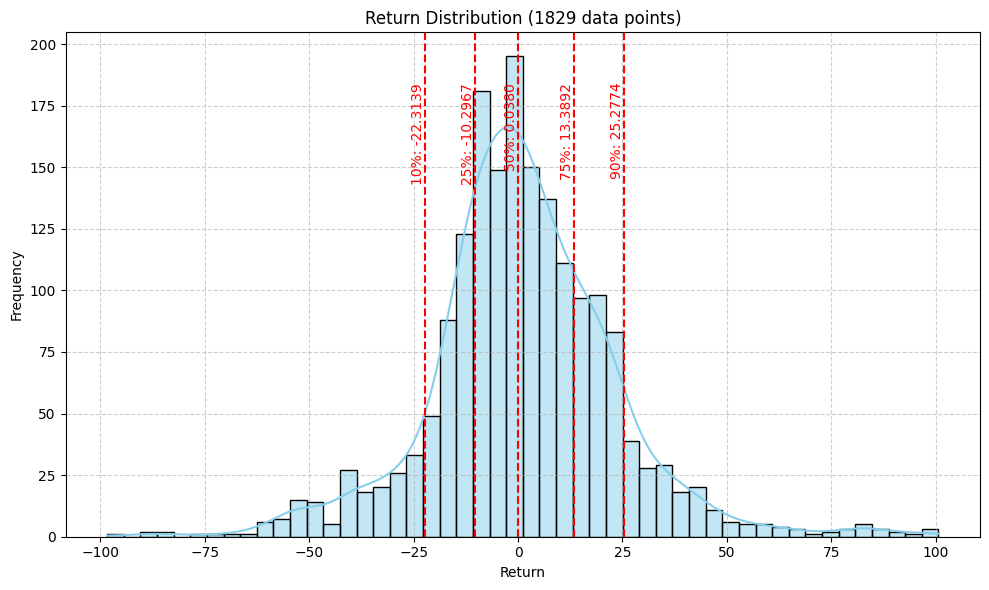

In [ ]:
plotReturnDistribution(results, 'return', absReturns=False)

In [ ]:
import numpy as np

returns = results['return']
win_rate = (returns > 0).mean()
avg_return = returns.mean()
median_return = returns.median()
sharpe = returns.mean() / returns.std()
max_drawdown = (results['return'].cumsum() - results['return'].cumsum().cummax()).min()


In [ ]:
returns[returns > 0]

,return
2,2.156276
3,15.966934
7,36.332010
8,36.676539
9,30.137140
...,...
1816,47.353325
1817,41.479158
1818,46.151929
1819,51.436689


In [36]:
import os
import json
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def train_autoencoder(
    model,
    X_train,
    X_val,
    model_name,
    model_info,
    ticker,
    folder_path,
    epochs=80,
    batch_size=16,
    optimizer='adam',
    loss='mae',
    seed=42,
    verbose=1
):
    """
    Trains the autoencoder model and saves the model, weights, and training history.

    Parameters:
    - model: Keras model instance to be trained.
    - X_train: Training data.
    - X_val: Validation data.
    - model_name: Name of the model.
    - model_info: Additional information about the model.
    - ticker: Identifier for the dataset or stock ticker.
    - folder_path: Directory to save the model and logs.
    - epochs: Number of training epochs.
    - batch_size: Size of training batches.
    - optimizer: Optimizer to compile the model.
    - loss: Loss function to compile the model.
    - seed: Random seed for reproducibility.
    - verbose: Verbosity mode.

    Returns:
    - history: Training history object.
    - model_path: Path to the saved model file.
    - weights_path: Path to the saved weights file.
    - history_path: Path to the saved training history JSON file.
    - csv_logger_path: Path to the saved CSV training log file.
    """
    # Set random seed for reproducibility
    set_seed(seed)

    # Ensure the folder path exists
    os.makedirs(folder_path, exist_ok=True)

    # Define file paths
    model_path = os.path.join(folder_path, f"{model_name}_{model_info}_{ticker}.keras")
    weights_path = os.path.join(folder_path, f"{model_name}_{model_info}_{ticker}.weights.h5")
    history_path = os.path.join(folder_path, f"{model_name}_{model_info}_{ticker}_history.json")
    csv_logger_path = os.path.join(folder_path, f"{model_name}_{model_info}_{ticker}_training_log.csv")

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)
    csv_logger = CSVLogger(csv_logger_path)

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss)

    # Train the model
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        validation_data=(X_val, X_val),
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint, csv_logger],
        verbose=verbose
    )

    # Save model weights separately
    model.save_weights(weights_path)

    # Save training history
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

    # Calculate reconstruction loss on training data
    train_reconstructions = model.predict(X_train, batch_size=batch_size, verbose=verbose)

    # Make sure both are numpy arrays
    train_reconstructions = np.array(train_reconstructions)
    X_train_np = np.array(X_train)

    # Now safely compute loss
    train_loss = tf.reduce_mean(tf.keras.losses.mae(train_reconstructions, X_train_np), axis=1).numpy()

    # Compute threshold as mean + std
    threshold = np.mean(train_loss) + np.std(train_loss)

    return history, model_path, weights_path, history_path, csv_logger_path, threshold

from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf

def predict_autoencoder(
    model_path,
    X_test,
    threshold=None,
    loss_fn='mae',
    batch_size=32,
    return_reconstructions=False,
    seed=42,
    verbose=0
):
    """
    Loads the saved model and uses it to make predictions and identify anomalies.

    Parameters:
    - model_path: Path to the saved model file (.keras or .h5).
    - X_test: Test data.
    - threshold: Threshold for anomaly detection. If None, it will be calculated.
    - loss_fn: Loss function to compute reconstruction error ('mae' or 'mse').
    - batch_size: Batch size for prediction.
    - return_reconstructions: Whether to return the reconstructed outputs.
    - seed: Random seed for reproducibility.
    - verbose: Verbosity mode during prediction.

    Returns:
    - test_loss: Reconstruction loss for each test sample.
    - threshold: Threshold used for anomaly detection.
    - anomalies: Boolean array indicating anomalies.
    - reconstructions (optional): Reconstructed outputs (only if return_reconstructions=True).
    """

    # Set random seed
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Load the saved model
    model = load_model(model_path)

    # Predict the reconstructions
    reconstructions = model.predict(X_test, batch_size=batch_size, verbose=verbose)

    # Calculate the reconstruction loss
    if loss_fn == 'mae':
        test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, X_test), axis=1).numpy()
    elif loss_fn == 'mse':
        test_loss = tf.reduce_mean(tf.keras.losses.mse(reconstructions, X_test), axis=1).numpy()
    else:
        raise ValueError("loss_fn must be either 'mae' or 'mse'.")

    # # Determine the threshold if not provided
    # if threshold is None:
    #     threshold = np.mean(test_loss) + np.std(test_loss)

    # Identify anomalies
    anomalies = test_loss > threshold

    if return_reconstructions:
        return test_loss, anomalies, reconstructions
    else:
        return test_loss, anomalies

def plot_loss_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

def plot_reconstructions(model, X_data, n_samples=5, random_seed=42):
    np.random.seed(random_seed)
    sample_idx = np.random.choice(len(X_data), size=n_samples, replace=False)
    sample_original = X_data[sample_idx]
    sample_reconstructed = model(sample_original)

    for i in range(n_samples):
        plt.figure(figsize=(10, 4))
        plt.plot(sample_original[i].flatten(), label="Original", linestyle='-')
        plt.plot(sample_reconstructed[i].numpy().flatten(), label="Reconstructed", linestyle='--')
        plt.title(f"Sample {i}: Original vs Reconstructed")
        plt.xlabel("Flattened Time-Series")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_loss_distribution(model, X_train, X_val, threshold=None):
    train_reconstructions = model(X_train)
    val_reconstructions = model(X_val)

    train_loss = tf.reduce_mean(tf.keras.losses.mae(train_reconstructions, X_train), axis=1).numpy()
    val_loss = tf.reduce_mean(tf.keras.losses.mae(val_reconstructions, X_val), axis=1).numpy()

    if threshold is None:
        threshold = np.mean(train_loss) + np.std(train_loss)

    plt.figure(figsize=(8,5))
    plt.hist(train_loss, bins=50, alpha=0.7, label='Train Loss')
    plt.hist(val_loss, bins=50, alpha=0.7, label='Validation Loss')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title('Reconstruction Loss Distribution')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Threshold used: {threshold:.4f}")

def evaluate_autoencoder(model, history, X_train, X_val, threshold=None, n_recon_samples=5, random_seed=42):
    """
    Evaluates an autoencoder model visually:
    Calls three helper functions:
    - Loss curves
    - Reconstructions
    - Loss distributions
    """
    plot_loss_curves(history)
    #plot_reconstructions(model, X_train, n_samples=n_recon_samples, random_seed=random_seed)
    plot_loss_distribution(model, X_train, X_val, threshold)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - loss: 0.2389 - val_loss: 0.1901
Epoch 2/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1873 - val_loss: 0.1837
Epoch 3/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1800 - val_loss: 0.1778
Epoch 4/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1745 - val_loss: 0.1766
Epoch 5/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1727 - val_loss: 0.1753
Epoch 6/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1720 - val_loss: 0.1739
Epoch 7/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1708 - val_loss: 0.1722
Epoch 8/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1690 - val_loss: 0.1722
Epoch 9/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1677 - val_loss: 0.1703
Epoch 10/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1665 - val_loss: 0.1711
Epoch 11/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1659 - val_loss: 0.1702
Epoch 12/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0

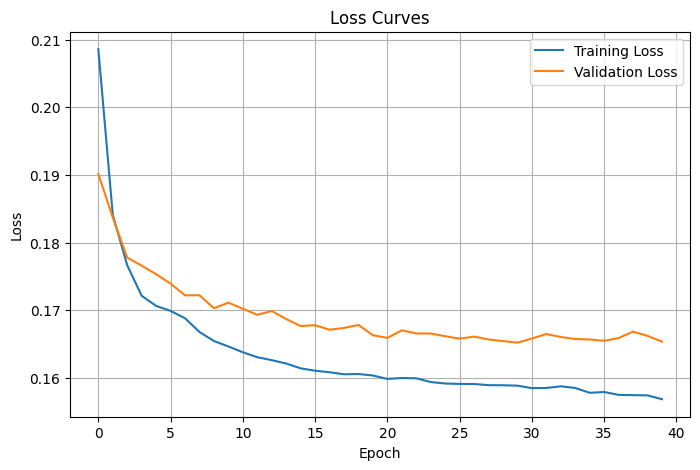

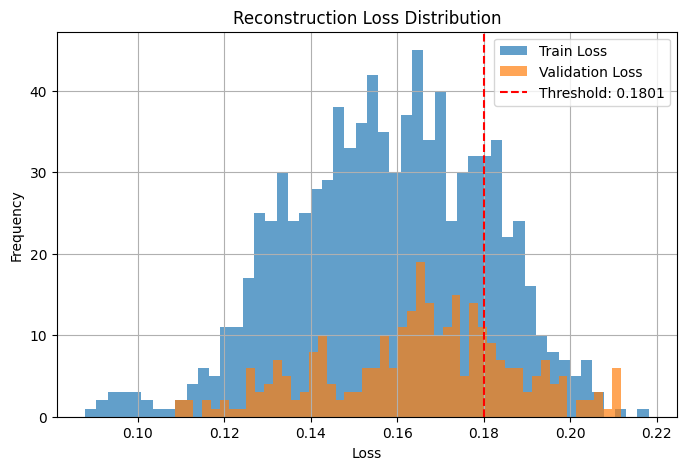

Threshold used: 0.1801
[Timestamp('2019-05-30 00:00:00'), Timestamp('2022-12-30 00:00:00')]


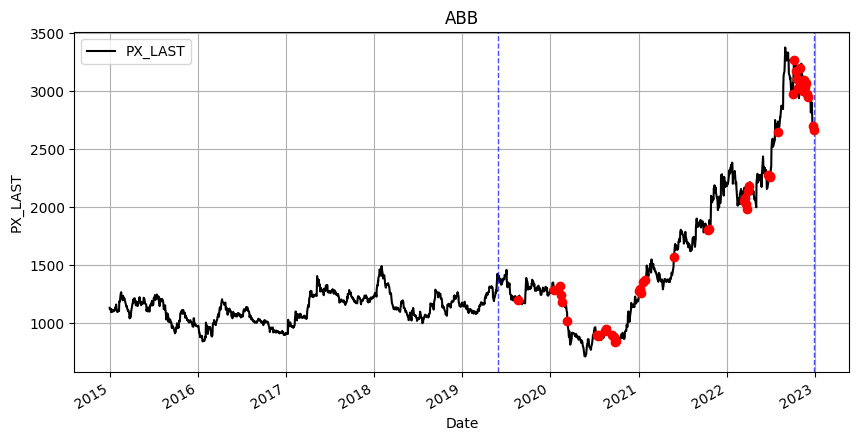

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 726ms/step - loss: 0.2813 - val_loss: 0.2026
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1975 - val_loss: 0.1978
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1940 - val_loss: 0.1973
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1921 - val_loss: 0.1964
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1912 - val_loss: 0.1952
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1901 - val_loss: 0.1936
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1860 - val_loss: 0.1901
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1822 - val_loss: 0.1891
Epoch 9/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1808 - val_loss: 0.1879
Epoch 10/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1787 - val_loss: 0.1875
Epoch 11/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1787 - val_loss: 0.1875
Epoch 12/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1776 - val

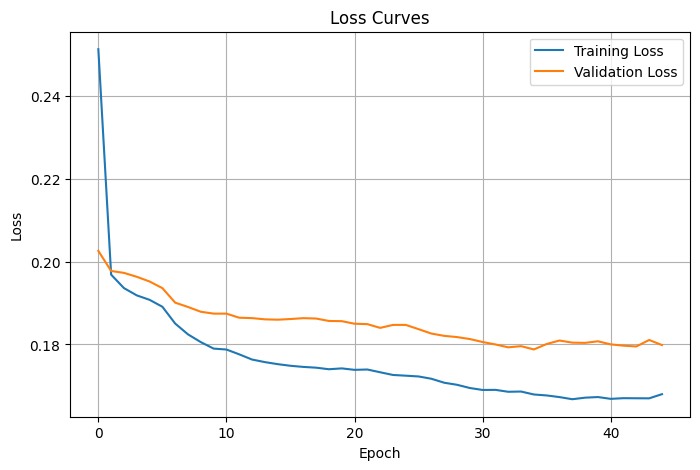

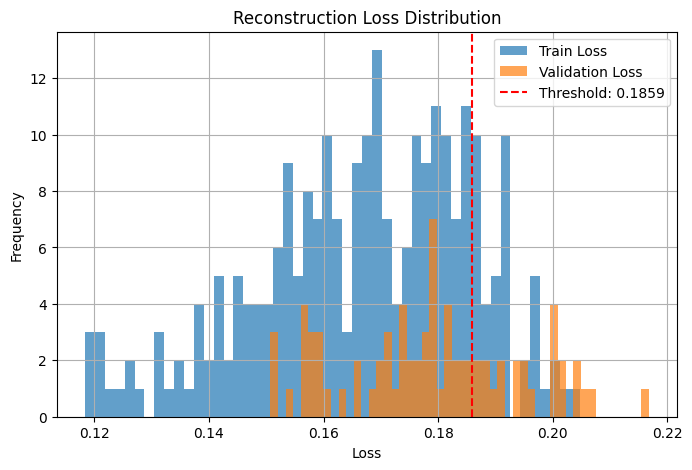

Threshold used: 0.1859
[Timestamp('2021-12-15 00:00:00'), Timestamp('2022-12-30 00:00:00')]


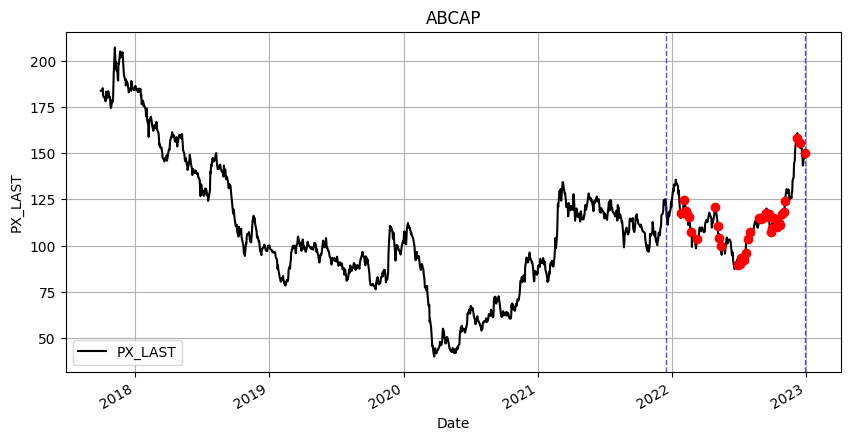

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - loss: 0.2425 - val_loss: 0.1892
Epoch 2/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1845 - val_loss: 0.1873
Epoch 3/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1823 - val_loss: 0.1799
Epoch 4/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1778 - val_loss: 0.1769
Epoch 5/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1746 - val_loss: 0.1747
Epoch 6/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1726 - val_loss: 0.1739
Epoch 7/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1714 - val_loss: 0.1722
Epoch 8/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1698 - val_loss: 0.1731
Epoch 9/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1692 - val_loss: 0.1702
Epoch 10/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1682 - val_loss: 0.1702
Epoch 11/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1676 - val_loss: 0.1713
Epoch 12/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1675 - val

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


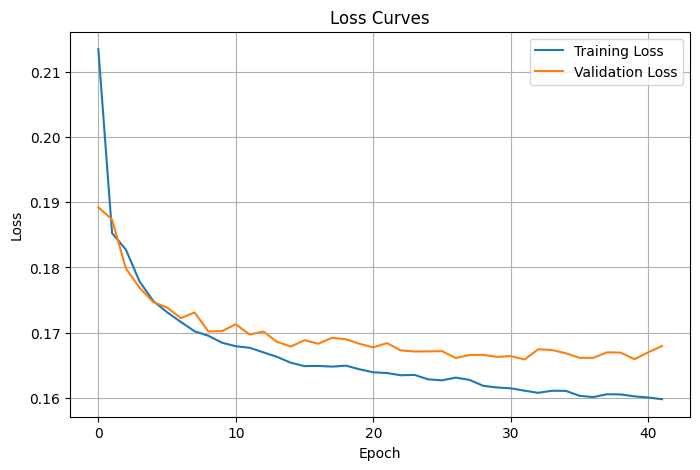

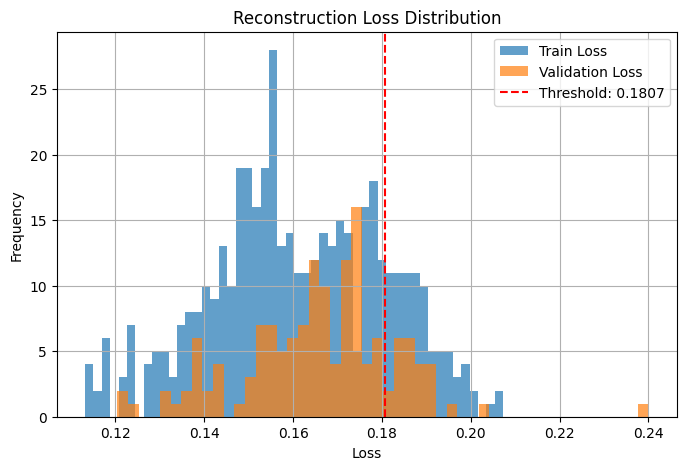

Threshold used: 0.1807
[Timestamp('2021-02-16 00:00:00'), Timestamp('2022-12-30 00:00:00')]


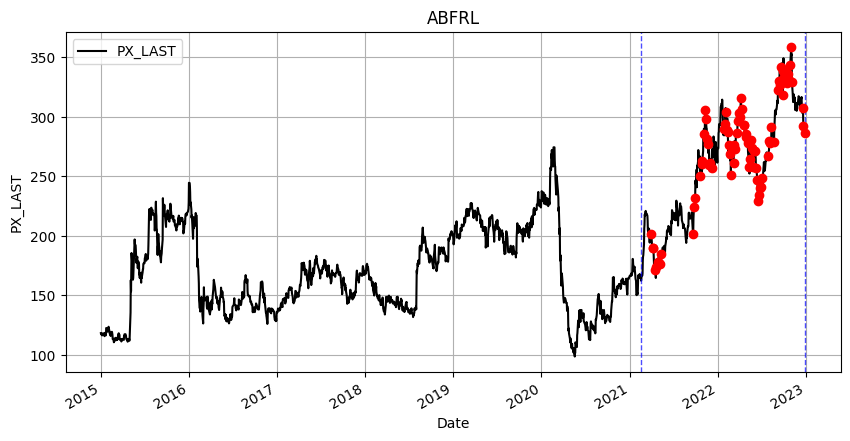

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - loss: 0.2482 - val_loss: 0.1965
Epoch 2/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1948 - val_loss: 0.1933
Epoch 3/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1873 - val_loss: 0.1848
Epoch 4/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1795 - val_loss: 0.1826
Epoch 5/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1753 - val_loss: 0.1798
Epoch 6/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1740 - val_loss: 0.1783
Epoch 7/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1726 - val_loss: 0.1773
Epoch 8/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1717 - val_loss: 0.1773
Epoch 9/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1713 - val_loss: 0.1756
Epoch 10/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1704 - val_loss: 0.1755
Epoch 11/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1688 - val_loss: 0.1745
Epoch 12/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1683 - val

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


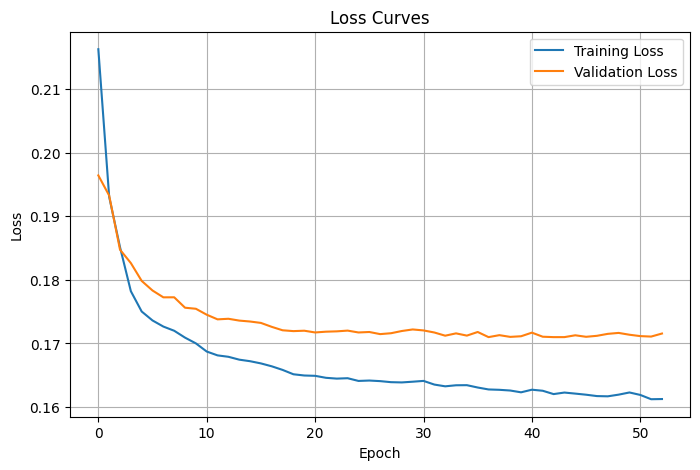

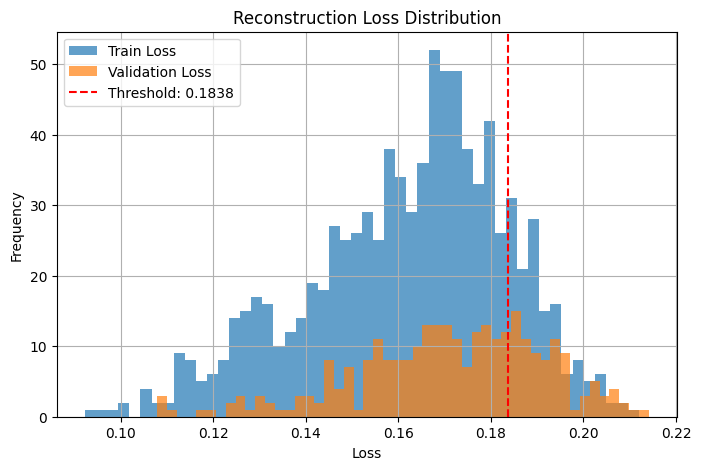

Threshold used: 0.1838
[Timestamp('2019-05-30 00:00:00'), Timestamp('2022-12-30 00:00:00')]


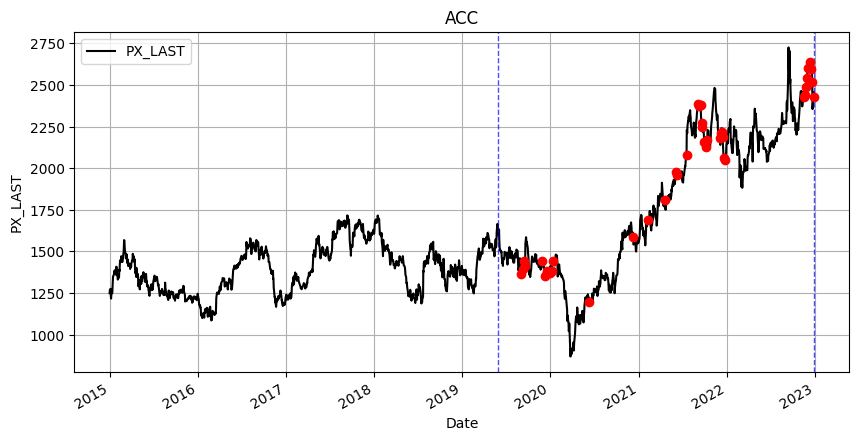

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - loss: 0.2488 - val_loss: 0.1999
Epoch 2/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1973 - val_loss: 0.1931
Epoch 3/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1894 - val_loss: 0.1879
Epoch 4/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1841 - val_loss: 0.1849
Epoch 5/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1817 - val_loss: 0.1815
Epoch 6/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1799 - val_loss: 0.1816
Epoch 7/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1766 - val_loss: 0.1789
Epoch 8/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1748 - val_loss: 0.1782
Epoch 9/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1731 - val_loss: 0.1777
Epoch 10/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1729 - val_loss: 0.1782
Epoch 11/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1717 - val_loss: 0.1786
Epoch 12/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1709 - val

KeyboardInterrupt: 

In [37]:
#TICKERS = CURR_UNIVERSE
TICKERS = CURR_UNIVERSE
PRICE_TYPE = 'PX_LAST'
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_max_ratio' ]
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_ratio' ]
#COLS_TO_KEEP = ['returnsClose','returnsOpen', 'returnsHigh', 'returnsLow', 'volume_max_ratio' ]
# COLS_TO_KEEP = [ 'volume_max_ratio', 'Price_Spread', 'Body_Size', 'Upper_Shadow', 'Lower_Shadow', 'Close_Open_Gap',
#                 'SMA_5', 'SMA_20', 'MACD', 'MACD_Signal', 'RSI', 'ATR', 'Bollinger_Upper', 'Bollinger_Lower', 'MFI', 'PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW' ]
# COLS_TO_KEEP = ['IDIO_log_ret_close_to_close', 'IDIO_log_ret_open_to_close',
#        'IDIO_log_ret_close_to_open', 'IDIO_log_ret_intraday_range', 'volume_ratio']
COLS_TO_KEEP= ['volume_ratio', 'Price_Spread', 'Body_Size', 'Upper_Shadow', 'Lower_Shadow', 'Close_Open_Gap' ]
# input_dim = 30
# latent_dim = 8
MODEL_INFO = "candle_features"

DATA_START_DATE = date(2005, 1, 1)
STEPS_FOR_DATA_GENERATION = 3
TIME_STEPS = 30
LATENT_DIM = 16
EPOCHS = 80
returnsAtAnomalies = {}

FOLDER_PATH = '/content/drive/My Drive/AnomalyDetection/23042025'

for ticker in TICKERS:
  try:
    prices = getStockPriceVolumeData(ticker, start=DATA_START_DATE)
    split_dates = get_split_dates(prices, split=(0.6, 0.2, 0.2))

    startTest = split_dates['test'][0]
    endTest = split_dates['test'][1]

    startVal = split_dates['val'][0]
    endVal = split_dates['val'][1]

    startTrain = split_dates['train'][0]
    endTrain = split_dates['train'][1]

    X_train, X_val, X_test, index_train, index_val, index_test = normalize_window_roll_by_date(prices, TIME_STEPS, STEPS_FOR_DATA_GENERATION, COLS_TO_KEEP, (startTrain, endTrain), (startVal, endVal), (startTest, endTest))

    autoencoder = LSTMAutoencoder(TIME_STEPS, len(COLS_TO_KEEP), LATENT_DIM)
    history, model_path, weights_path, history_path, csv_logger_path, threshold = train_autoencoder(autoencoder, X_train, X_val, autoencoder.__class__.__name__, MODEL_INFO, ticker, FOLDER_PATH, epochs=EPOCHS)
    test_loss, anomalies = predict_autoencoder(model_path, X_test, threshold=threshold, return_reconstructions=False)

    evaluate_autoencoder(autoencoder, history, X_train, X_val, threshold, 5)

    anomaly_dates = [dates[-1] for dates, flag in zip(index_test, anomalies) if flag]
    anomaly_reconstruction_errors = [loss for loss, flag in zip(test_loss, anomalies) if flag]

    returns = calculate_vol_factor_normalized_returns(prices, anomaly_dates, equal_weighted_index_returns)
    returns_df = returns.copy()
    returns_df["Reconstruction_Error"] = anomaly_reconstruction_errors

    # Store it
    returnsAtAnomalies[ticker] = returns_df

    returnsAtAnomaliesDf = pd.concat(
      [df.assign(Ticker=ticker) for ticker, df in returnsAtAnomalies.items()],
      ignore_index=True
  )

    returnsAtAnomaliesDf.to_csv(FOLDER_PATH + '/' + 'results' + autoencoder.__class__.__name__ +"_" + MODEL_INFO + '.csv')
    plotPrice(ticker, PRICE_TYPE, date(2015, 1, 1), None, anomaly_dates, lineDates=[startTest, endTest], folder_path=FOLDER_PATH, saveSuffix=autoencoder.__class__.__name__ + MODEL_INFO)

  except Exception as e:
    print(f"Error processing {ticker}: {e}")


In [ ]:
returns_df

,Anomaly Date,Price at Anomaly,Stock Vol,Index Vol,Vol Ratio,3M Return,3M Normalized,6M Return,6M Normalized,Reconstruction_Error
0,2022-11-03,3200.15,0.020613,0.009543,2.160162,None,None,None,None,0.258196
1,2022-11-14,3001.66,0.021956,0.009694,2.265048,None,None,None,None,0.251641
2,2022-11-17,3097.90,0.021764,0.009562,2.276032,None,None,None,None,0.263388
3,2022-11-22,3035.64,0.021834,0.009403,2.321971,None,None,None,None,0.254580
4,2022-11-25,3066.79,0.020363,0.009079,2.242920,None,None,None,None,0.259341
5,2022-12-26,2703.44,0.020308,0.009487,2.140522,None,None,None,None,0.237131


In [ ]:
evaluate_predictions(returnsAtAnomaliesDf)

In [ ]:
returnsAtAnomaliesDf

,Anomaly Date,Price at Anomaly,Stock Vol,Index Vol,Vol Ratio,3M Return,3M Normalized,6M Return,6M Normalized,Ticker
0,2020-11-03,865.24,0.016905,0.011404,1.482376,64.969257,43.827785,59.230965,39.956775,ABB
1,2021-04-30,1367.09,0.019760,0.013131,1.504785,23.015310,15.294748,50.565800,33.603335,ABB
2,2021-05-17,1406.18,0.017482,0.012184,1.434782,22.854115,15.928631,54.264034,37.820399,ABB
3,2021-07-27,1652.03,0.015974,0.006106,2.616240,12.614178,4.821491,33.268766,12.716251,ABB
4,2021-08-03,1653.57,0.016142,0.006107,2.643318,23.836910,9.017798,38.014115,14.381211,ABB
5,2021-10-14,1800.35,0.016832,0.007551,2.229150,28.727192,12.887059,20.038326,8.989221,ABB
6,2021-10-22,1889.72,0.016961,0.008033,2.111535,26.140381,12.379801,13.188197,6.245787,ABB
7,2021-12-21,2178.43,0.024353,0.011265,2.161760,-4.977438,-2.302493,1.472620,0.681213,ABB
8,2022-02-09,2218.02,0.023834,0.012009,1.984640,3.143795,1.584063,23.932156,12.058689,ABB
9,2022-03-10,2135.82,0.020022,0.015404,1.299741,8.398180,6.461423,54.680170,42.070038,ABB


#Direction of trade

#Quality of Trade

#Volume normalization (DON)

#Remove index component (NEED INDEX TIME SERIES)

#Use all features (DONE)

# Need to have recent test period and have a look at stocks where we do n't have anough data like Adani etc...

# Rough

In [ ]:
TICKER = 'SBIN'
PRICE_TYPE = 'PX_LAST'
prices = getStockPriceVolumeData(TICKER, start=date(2010, 1, 1))[PRICE_TYPE]
prices.rename('price', inplace=True)
prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.

In [ ]:
# should we smoothen the data ?
X, index_map = normalize_window_roll(prices,30)

In [ ]:
print(X.shape)
print(prices.shape)
print(len(index_map))

(1132, 30, 5)
(5690, 49)
1132


In [ ]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_val = X[train_size+test_size:train_size+val_size+test_size]
X_test = X[train_size:train_size+test_size]

val_index_offset = train_size + test_size
test_index_offset = train_size
#X_val = X[train_size+test_size:train_size+test_size+val_size]

In [ ]:
'''
Training the model: The autoencoder is trained using the stock market data using the fit function.
An EarlyStopping callback is added to stop the training if the validation loss does not improve for 2 consecutive epochs.
'''
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=80,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])

In [ ]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
np.mean(train_loss)

In [ ]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
preds = predict(autoencoder, X_test, threshold)

In [ ]:
preds

In [ ]:
anomalous_test_data = X_test[np.where(preds==False)]

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for p in [1,10,20]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

#Visualize on original price plot

In [ ]:
anomalousIndexIds  = np.where(preds == False)[0]
anomalousIndexIds = [ int(test_index_offset + id) for id in anomalousIndexIds ]

In [ ]:
#dotDates = [date for i in anomalousIndexIds for date in index_map[i]]
dotDates = [index_map[i][0] for i in anomalousIndexIds]

In [ ]:
dotDates

In [ ]:
plotPrice(TICKER, 'PX_LAST', date(2013, 1, 1), None, dotDates, lineDates=[index_map[val_index_offset][0], index_map[test_index_offset][0]])

In [ ]:
ticker

In [ ]:
prices.index[test_index_offset]

In [ ]:
val_index_offset

In [ ]:
test_index_offset